Product Back Order Prediction

Product Back orders *What is a backorder? : A customer order that has not been fulfilled. A backorder generally indicates that customer demand for a product or service exceeds a company’s capacity to supply it. Total backorders, also known as backlog, may be expressed in terms of units or dollar amount. *Product backorder may be the result of strong sales performance (e.g. the product is in such high demand that production cannot keep up with sales). However, backorders can upset consumers, lead to canceled orders and decreased customer loyalty. Companies want to avoid backorders, but also avoid overstocking every product (leading to higher inventory costs). *Machine learning can identify patterns related to backorders before customers order. Production can then adjust to minimize delays while customer service can provide accurate dates to keep customers informed and happy. The predictive analytics approach enables the maximum product to get in the hands of customers at the lowest cost to the organization.
Feature Description

DATA : The data file contains the historical data for the 8 weeks prior to the week we are trying to predict. The data were taken as weekly snapshots at the start of each week. The target (or response) is the went_on_backorder variable. To model and predict the target, we’ll use the other features, which include:

sku – Random ID for the product national_inv – Current inventory level for the part lead_time – Transit time for product (if available) in_transit_qty – Amount of product in transit from source forecast_3_month – Forecast sales for the next 3 months forecast_6_month – Forecast sales for the next 6 months forecast_9_month – Forecast sales for the next 9 months sales_1_month – Sales quantity for the prior 1 month time period sales_3_month – Sales quantity for the prior 3 month time period sales_6_month – Sales quantity for the prior 6 month time period sales_9_month – Sales quantity for the prior 9 month time period min_bank – Minimum recommend amount to stock potential_issue – Source issue for part identified pieces_past_due – Parts overdue from source perf_6_month_avg – Source performance for prior 6 month period perf_12_month_avg – Source performance for prior 12 month period local_bo_qty – Amount of stock orders overdue deck_risk – Part risk flag oe_constraint – Part risk flag ppap_risk – Part risk flag stop_auto_buy – Part risk flag rev_stop – Part risk flag went_on_backorder – Product actually went on backorder. This is the target value.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve, confusion_matrix, classification_report,accuracy_score,precision_score,recall_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score,accuracy_score
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2,shapiro,mannwhitneyu,chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection
from scipy import stats
from collections import Counter

c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


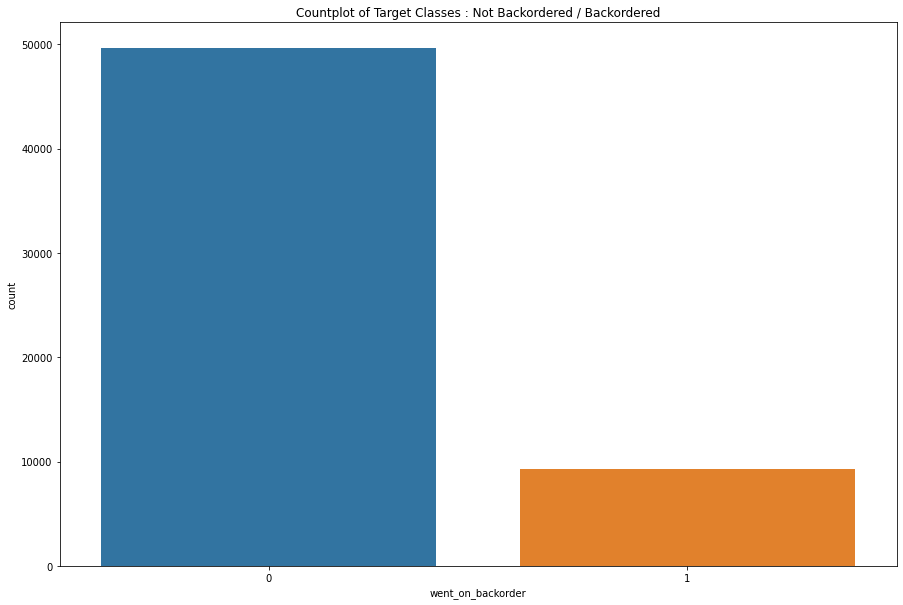

0    0.842241
1    0.157759
Name: went_on_backorder, dtype: float64

In [2]:
df = pd.read_csv(r'C:\Users\admin\Desktop\kaggle\train.csv')
plt.figure(figsize=(15,10))
sns.countplot(df['went_on_backorder'])
plt.title('Countplot of Target Classes : Not Backordered / Backordered')
plt.show()

df['went_on_backorder'].value_counts(normalize=True)

In [3]:
# 挂载数据
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

df_train = train.copy(deep=True)
df_test = test.copy(deep=True)

print("Number of rows are: ",df_train.shape[0],"\nNumber of columns are : ",df_train.shape[1])
print("Number of rows are: ",df_test.shape[0],"\nNumber of columns are : ",df_test.shape[1])

Number of rows are:  58919 
Number of columns are :  23
Number of rows are:  25252 
Number of columns are :  22


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58919 entries, 0 to 58918
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sku                58919 non-null  int64  
 1   national_inv       58919 non-null  int64  
 2   lead_time          58919 non-null  int64  
 3   in_transit_qty     58919 non-null  int64  
 4   forecast_3_month   58919 non-null  int64  
 5   forecast_6_month   58919 non-null  int64  
 6   forecast_9_month   58919 non-null  int64  
 7   sales_1_month      58919 non-null  int64  
 8   sales_3_month      58919 non-null  int64  
 9   sales_6_month      58919 non-null  int64  
 10  sales_9_month      58919 non-null  int64  
 11  min_bank           58919 non-null  int64  
 12  potential_issue    58919 non-null  int64  
 13  pieces_past_due    58919 non-null  int64  
 14  perf_6_month_avg   58919 non-null  float64
 15  perf_12_month_avg  58919 non-null  float64
 16  local_bo_qty       589

In [5]:
# df_train['source']=df_train['pieces_past_due']*(1-df_train['perf_6_month_avg'])*(1-df_train['perf_12_month_avg'])

In [6]:
# df_train['risk']=(df_train['deck_risk']+df_train['oe_constraint']+df_train['ppap_risk']+df_train['rev_stop'])*df_train['stop_auto_buy']
# df_train['risk']=+df_train['oe_constraint']+df_train['potential_issue']

In [7]:
# df_train.loc[(df_train.risk > 2),  'risksign'] =2
# df_train.loc[(df_train.risk > 0), 'risksign'] = df_train.risk*10
# df_train.loc[(df_train.risk <= 0), 'risksign'] = 0

In [8]:
# df_train['national_inv'] = df_train['national_inv'] - df_train['min_bank']


In [9]:
# 定货到了还是爆炸
df_train.loc[(df_train.lead_time <= 1), 'firstboom'] = df_train.national_inv+df_train.in_transit_qty-df_train.min_bank-df_train.sales_1_month-df_train.pieces_past_due
df_train.loc[(df_train.lead_time > 1)&(df_train.lead_time <= 3),  'firstboom'] = df_train.national_inv+df_train.in_transit_qty-df_train.min_bank-df_train.forecast_3_month-df_train.pieces_past_due
df_train.loc[(df_train.lead_time > 3)&(df_train.lead_time <= 6),  'firstboom'] = df_train.national_inv+df_train.in_transit_qty-df_train.min_bank-df_train.forecast_6_month-df_train.pieces_past_due
df_train.loc[(df_train.lead_time > 6)&(df_train.lead_time <= 9),  'firstboom'] = df_train.national_inv+df_train.in_transit_qty-df_train.min_bank-df_train.forecast_9_month-df_train.pieces_past_due
df_train.loc[(df_train.lead_time > 9),  'firstboom'] = df_train.national_inv+df_train.in_transit_qty-df_train.forecast_9_month*1.5-df_train.min_bank-df_train.pieces_past_due

In [10]:
df_train.loc[(df_train.lead_time <= 1), 'firstboomh'] = df_train.national_inv+df_train.in_transit_qty-df_train.min_bank-df_train.sales_1_month-df_train.pieces_past_due
df_train.loc[(df_train.lead_time > 1)&(df_train.lead_time <= 3),  'firstboomh'] = df_train.national_inv+df_train.in_transit_qty-df_train.min_bank-df_train.sales_3_month-df_train.pieces_past_due
df_train.loc[(df_train.lead_time > 3)&(df_train.lead_time <= 6),  'firstboomh'] = df_train.national_inv+df_train.in_transit_qty-df_train.min_bank-df_train.sales_6_month-df_train.pieces_past_due
df_train.loc[(df_train.lead_time > 6)&(df_train.lead_time <= 9),  'firstboomh'] = df_train.national_inv+df_train.in_transit_qty-df_train.min_bank-df_train.sales_9_month-df_train.pieces_past_due
df_train.loc[(df_train.lead_time > 9),  'firstboomh'] = df_train.national_inv+df_train.in_transit_qty-df_train.sales_9_month*1.5-df_train.min_bank-df_train.pieces_past_due

In [11]:
# 定货未到就爆炸
df_train.loc[(df_train.lead_time <= 1), 'secondboom'] = df_train.national_inv-df_train.min_bank-df_train.lead_time*df_train.sales_1_month-df_train.pieces_past_due
df_train.loc[(df_train.lead_time > 1)&(df_train.lead_time <= 3),  'secondboom'] = df_train.national_inv-df_train.min_bank-df_train.lead_time*df_train.forecast_3_month/3-df_train.pieces_past_due
df_train.loc[(df_train.lead_time > 3)&(df_train.lead_time <= 6),  'secondboom'] = df_train.national_inv-df_train.min_bank-df_train.lead_time*df_train.forecast_6_month/6-df_train.pieces_past_due
df_train.loc[(df_train.lead_time > 6)&(df_train.lead_time <= 9),  'secondboom'] = df_train.national_inv-df_train.min_bank-df_train.lead_time*df_train.forecast_9_month/9-df_train.pieces_past_due
df_train.loc[(df_train.lead_time > 9),  'secondboom'] = df_train.national_inv-df_train.min_bank-df_train.lead_time*df_train.forecast_9_month/9-df_train.pieces_past_due

In [12]:
df_train.loc[(df_train.lead_time <= 1), 'secondboomh'] = df_train.national_inv-df_train.lead_time*df_train.sales_1_month-df_train.min_bank-df_train.pieces_past_due
df_train.loc[(df_train.lead_time > 1)&(df_train.lead_time <= 3),  'secondboomh'] = df_train.national_inv-df_train.lead_time*df_train.sales_3_month/3-df_train.min_bank-df_train.pieces_past_due
df_train.loc[(df_train.lead_time > 3)&(df_train.lead_time <= 6),  'secondboomh'] = df_train.national_inv-df_train.lead_time*df_train.sales_6_month/6-df_train.min_bank-df_train.pieces_past_due
df_train.loc[(df_train.lead_time > 6)&(df_train.lead_time <= 9),  'secondboomh'] = df_train.national_inv-df_train.lead_time*df_train.sales_9_month/9-df_train.min_bank-df_train.pieces_past_due
df_train.loc[(df_train.lead_time > 9),  'secondboomh'] = df_train.national_inv-df_train.lead_time*df_train.sales_9_month/9-df_train.min_bank-df_train.pieces_past_due

In [13]:
# # 定货延期导致爆炸
# df_train.loc[(df_train.lead_time <= 1), 'firstboom'] = df_train.national_inv+df_train.in_transit_qty-df_train.min_bank-df_train.sales_1_month-df_train.pieces_past_due
# df_train.loc[(df_train.lead_time > 1)&(df_train.lead_time <= 3),  'firstboom'] = df_train.national_inv+df_train.in_transit_qty-df_train.min_bank-df_train.forecast_3_month-df_train.pieces_past_due
# df_train.loc[(df_train.lead_time > 3)&(df_train.lead_time <= 6),  'firstboom'] = df_train.national_inv+df_train.in_transit_qty-df_train.min_bank-df_train.forecast_6_month-df_train.pieces_past_due
# df_train.loc[(df_train.lead_time > 6)&(df_train.lead_time <= 9),  'firstboom'] = df_train.national_inv+df_train.in_transit_qty-df_train.min_bank-df_train.forecast_9_month-df_train.pieces_past_due
# df_train.loc[(df_train.lead_time > 9),  'firstboom'] = df_train.national_inv+df_train.in_transit_qty-df_train.forecast_9_month*1.5-df_train.min_bank-df_train.pieces_past_due

In [14]:
# 现货加订货撑不到下次订货
df_train.loc[(df_train.lead_time <= 1), 'boom'] = df_train.national_inv+df_train.in_transit_qty-df_train.min_bank-df_train.lead_time*df_train.sales_1_month-df_train.pieces_past_due
df_train.loc[(df_train.lead_time > 1)&(df_train.lead_time <= 3),  'boom'] = df_train.national_inv+df_train.in_transit_qty-df_train.min_bank-df_train.lead_time*df_train.forecast_3_month/3-df_train.pieces_past_due
df_train.loc[(df_train.lead_time > 3)&(df_train.lead_time <= 6),  'boom'] = df_train.national_inv+df_train.in_transit_qty-df_train.min_bank-df_train.lead_time*df_train.forecast_6_month/6-df_train.pieces_past_due
df_train.loc[(df_train.lead_time > 6)&(df_train.lead_time <= 9),  'boom'] = df_train.national_inv+df_train.in_transit_qty-df_train.min_bank-df_train.lead_time*df_train.forecast_9_month/9-df_train.pieces_past_due
df_train.loc[(df_train.lead_time > 9),  'boom'] = df_train.national_inv+df_train.in_transit_qty-df_train.lead_time*df_train.forecast_9_month-df_train.min_bank-df_train.pieces_past_due

In [15]:
# for a,label in [[df_train.firstboom,'one'],[df_train.firstboomh,'oneh'],[df_train.secondboom,'two'],[df_train.secondboomh,'twoh']]:
#     df_train.loc[(a > 20) ,  label] =0
#     df_train.loc[(a <= -5000) ,  label] =0
#     df_train.loc[(a <= 20)&(a > -5000), label] = 1

# df_train.one.fillna(0)
# df_train.two.fillna(0)

In [16]:
df_train

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder,firstboom,firstboomh,secondboom,secondboomh,boom
0,2,4,2,0,0,0,0,0,0,0,...,0,0,1,0,0,4.0,4.0,4.000000,4.000000,4.000000
1,5,2,16,0,0,0,0,0,0,0,...,0,0,1,0,0,1.0,1.0,1.000000,1.000000,1.000000
2,7,4,4,0,0,0,0,0,0,0,...,0,0,1,0,0,4.0,4.0,4.000000,4.000000,4.000000
3,9,0,9,0,1,1,1,0,0,0,...,0,0,1,0,0,-1.0,0.0,-1.000000,0.000000,-1.000000
4,10,300,8,0,0,0,0,0,40,100,...,0,0,1,0,0,293.0,171.0,293.000000,184.555556,293.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58914,84165,11,8,0,0,0,0,2,6,17,...,0,0,1,0,0,5.0,-21.0,5.000000,-18.111111,5.000000
58915,84166,0,8,0,4,5,7,2,3,4,...,0,0,1,0,1,-7.0,-5.0,-6.222222,-4.444444,-6.222222
58916,84167,0,2,0,1,1,1,0,0,0,...,0,0,1,0,1,-1.0,0.0,-0.666667,0.000000,-0.666667
58917,84169,6,4,0,0,0,0,0,0,0,...,0,0,1,0,0,6.0,6.0,6.000000,6.000000,6.000000


In [17]:
# df_train.loc[(df_train.national_inv <= 500),  'inv'] =1
# df_train.loc[(df_train.national_inv > 500) & (df_train.national_inv < 5000),  'inv'] =0
# df_train.loc[(df_train.national_inv >= 5000),  'inv'] =0

In [18]:
# df_train.loc[(df_train.sku != 0),  'pred'] = 0
# for i in [df_train.one,df_train.oneh,df_train.two,df_train.twoh,df_train.inv]:
#     df_train.loc[(i == 0),  'pred'] = 0
# df_train.loc[(df_train.national_inv > 500) & (df_train.national_inv < 5000),  'pred'] =0
# df_train.loc[(df_train.national_inv >= 5000),  'pred'] =0

In [19]:
# forecasts = ['pred','inv']
# sns.pairplot(df_train, vars=forecasts, hue='went_on_backorder', size=5)
# fig = plt.figure(figsize = (20 , 12))
# plt.show()

In [20]:
# forecasts = ['inv','national_inv']
# sns.pairplot(df_train, vars=forecasts, hue='went_on_backorder', size=5)
# fig = plt.figure(figsize = (20 , 12))
# plt.show()

In [21]:
# forecasts = ['sku','national_inv']
# sns.pairplot(df_train, vars=forecasts, hue='went_on_backorder', size=5)
# fig = plt.figure(figsize = (20 , 12))
# plt.show()

In [22]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
sku,58919.0,42053.601249,24301.057174,2.0,21068.500000,41948.000000,63047.00,84171.000000
national_inv,58919.0,199.403927,1529.148278,-401.0,3.000000,11.000000,54.00,75813.000000
lead_time,58919.0,6.915698,3.522995,0.0,4.000000,8.000000,8.00,28.000000
in_transit_qty,58919.0,17.140753,117.750387,0.0,0.000000,0.000000,0.00,3872.000000
forecast_3_month,58919.0,87.252890,497.820231,0.0,0.000000,0.000000,12.00,15600.000000
forecast_6_month,58919.0,162.178567,913.339877,0.0,0.000000,0.000000,26.00,29200.000000
forecast_9_month,58919.0,237.743784,1345.784311,0.0,0.000000,0.000000,40.00,43000.000000
sales_1_month,58919.0,25.505202,136.604848,0.0,0.000000,0.000000,6.00,4934.000000
sales_3_month,58919.0,82.252991,430.185496,0.0,0.000000,2.000000,18.00,13554.000000
sales_6_month,58919.0,163.349140,860.764496,0.0,0.000000,4.000000,35.00,26299.000000


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\seaborn\axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


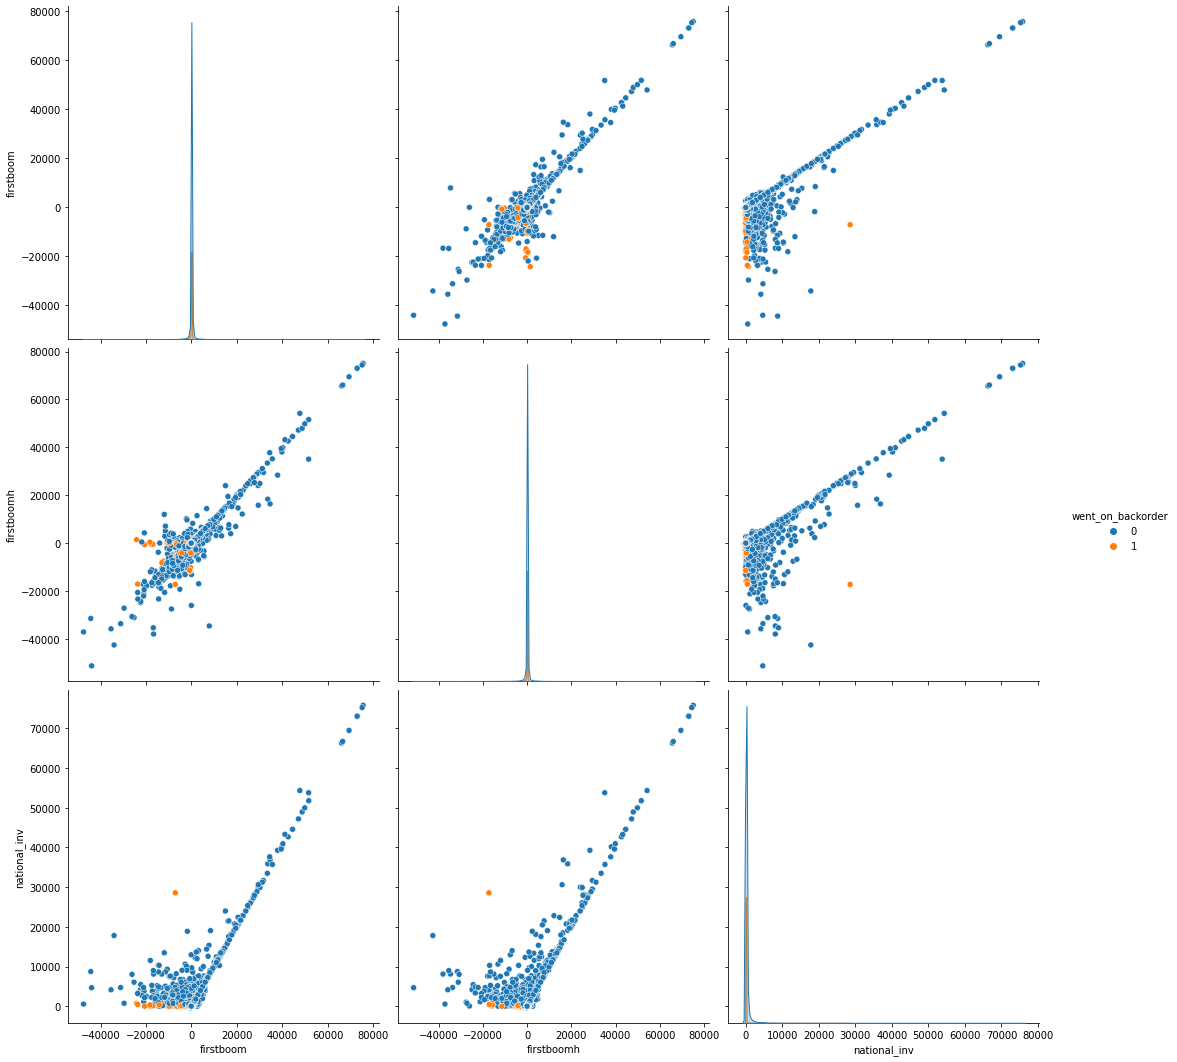

<Figure size 1440x864 with 0 Axes>

In [23]:
forecasts = ['firstboom','firstboomh','national_inv']
sns.pairplot(df_train, vars=forecasts, hue='went_on_backorder', size=5)
fig = plt.figure(figsize = (20 , 12))
plt.show()

In [24]:
# forecasts = ['secondboom','secondboomh','national_inv']
# sns.pairplot(df_train, vars=forecasts, hue='went_on_backorder', size=5)
# fig = plt.figure(figsize = (20 , 12))
# plt.show()

In [25]:
# forecasts = ['one','oneh','two','twoh']
# sns.pairplot(df_train, vars=forecasts, hue='went_on_backorder', size=5)
# fig = plt.figure(figsize = (20 , 12))
# plt.show()

In [26]:
# plt.hist(x = df_train["source"] , bins = 15,color = "orange")
# plt.title('Histogram of source')
# plt.figure(figsize=(20,15))
# plt.show()
# plt.hist(x = df_train["pieces_past_due"] , bins = 15,color = "orange")
# plt.title('Histogram of pieces_past_due')
# plt.figure(figsize=(20,15))
# plt.show()

In [27]:
df_train.isnull().sum()

sku                  0
national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
went_on_backorder    0
firstboom            0
firstboomh           0
secondboom           0
secondboomh          0
boom                 0
dtype: int64

c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


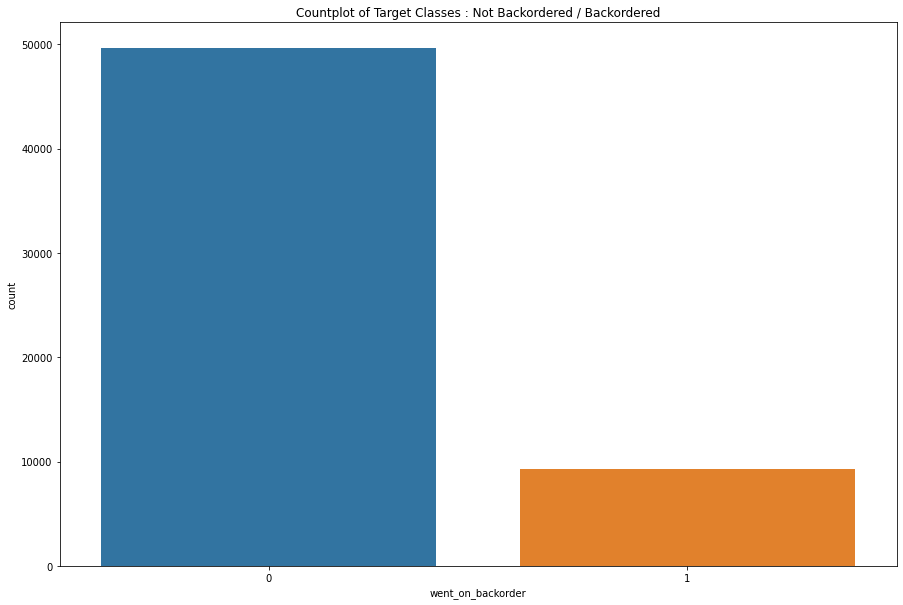

0    0.842241
1    0.157759
Name: went_on_backorder, dtype: float64

In [28]:
plt.figure(figsize=(15,10))
sns.countplot(df_train['went_on_backorder'])
plt.title('Countplot of Target Classes : Not Backordered / Backordered')
plt.show()

df_train['went_on_backorder'].value_counts(normalize=True)

In [29]:
# 以是否延期交货为分界做数据透视表
catvar = []
for i in df_train:
    catvar.append(i)

df_train.pivot_table(values=catvar[1:7],index=['went_on_backorder'])

,forecast_3_month,forecast_6_month,forecast_9_month,in_transit_qty,lead_time,national_inv
went_on_backorder,,,,,,
0,84.315513,161.941218,241.071800,19.687752,7.036938,233.864844
1,102.934911,163.445724,219.976224,3.542873,6.268424,15.424529


In [30]:
df_train.pivot_table(values=catvar[7:13],index=['went_on_backorder'])

,min_bank,potential_issue,sales_1_month,sales_3_month,sales_6_month,sales_9_month
went_on_backorder,,,,,,
0,27.777164,0.000504,26.610269,86.916653,174.642391,265.832279
1,17.491339,0.003873,19.605487,57.354707,103.056912,155.788811


In [31]:
df_train.pivot_table(values=catvar[12:17],index=['went_on_backorder'])

,local_bo_qty,perf_12_month_avg,perf_6_month_avg,pieces_past_due,potential_issue
went_on_backorder,,,,,
0,0.109221,0.780045,0.783839,0.670643,0.000504
1,1.205164,0.707146,0.707314,2.585476,0.003873


In [32]:
# 以下五个为0-1二元的部分风险指标
df_train.pivot_table(values=catvar[17:22],index=['went_on_backorder'])

,deck_risk,oe_constraint,ppap_risk,rev_stop,stop_auto_buy
went_on_backorder,,,,,
0,0.184850,0.000121,0.115650,0.000262,0.983718
1,0.156966,0.000538,0.149112,0.000215,0.974072


In [33]:
df_train.pivot_table(values=catvar[23:],index=['went_on_backorder'])

,boom,firstboom,firstboomh,secondboom,secondboomh
went_on_backorder,,,,,
0,-210.418333,28.627801,-3.206412,36.146679,7.163807
1,-400.888985,-192.468101,-138.533082,-168.040105,-123.505367


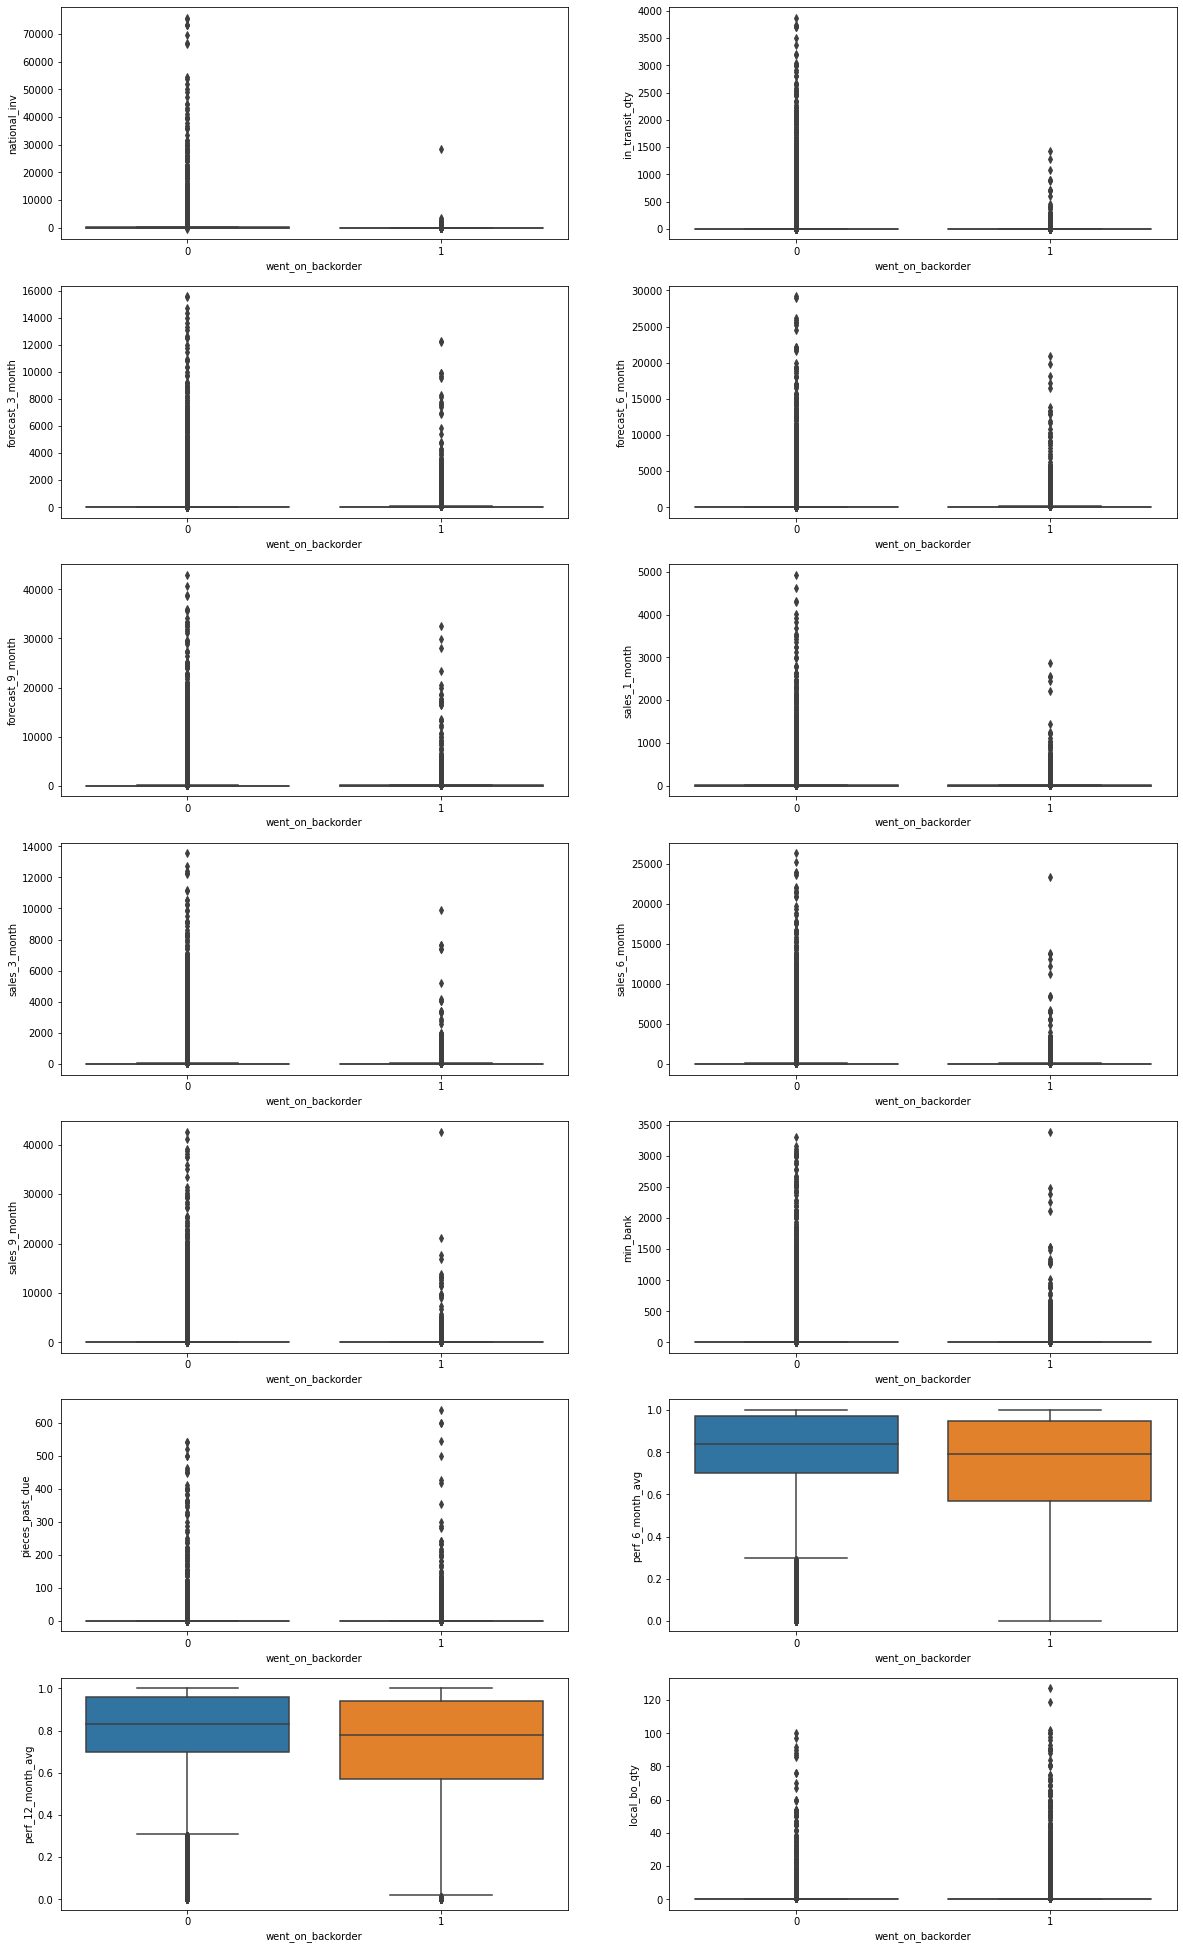

In [34]:
# 具体涂鸦图形式显示

fig,axes = plt.subplots(7,2,figsize=(20,35))

sns.boxplot(y = df_train['national_inv'],x=df_train['went_on_backorder'],ax=axes[0,0])
sns.boxplot(y = df_train['in_transit_qty'],x=df_train['went_on_backorder'],ax=axes[0,1])
sns.boxplot(y = df_train['forecast_3_month'],x=df_train['went_on_backorder'],ax=axes[1,0])
sns.boxplot(y = df_train['forecast_6_month'],x=df_train['went_on_backorder'],ax=axes[1,1])
sns.boxplot(y = df_train['forecast_9_month'],x=df_train['went_on_backorder'],ax=axes[2,0])
sns.boxplot(y = df_train['sales_1_month'],x=df_train['went_on_backorder'],ax=axes[2,1])
sns.boxplot(y = df_train['sales_3_month'],x=df_train['went_on_backorder'],ax=axes[3,0])
sns.boxplot(y = df_train['sales_6_month'],x=df_train['went_on_backorder'],ax=axes[3,1])
sns.boxplot(y = df_train['sales_9_month'],x=df_train['went_on_backorder'],ax=axes[4,0])
sns.boxplot(y = df_train['min_bank'],x=df_train['went_on_backorder'],ax=axes[4,1])
sns.boxplot(y = df_train['pieces_past_due'],x=df_train['went_on_backorder'],ax=axes[5,0])
sns.boxplot(y = df_train['perf_6_month_avg'],x=df_train['went_on_backorder'],ax=axes[5,1])
sns.boxplot(y = df_train['perf_12_month_avg'],x=df_train['went_on_backorder'],ax=axes[6,0])
sns.boxplot(y = df_train['local_bo_qty'],x=df_train['went_on_backorder'],ax=axes[6,1])

plt.show()

The skewness of sku is 0.0041933890484008324
The kurtosis of sku is -1.1972423280642062


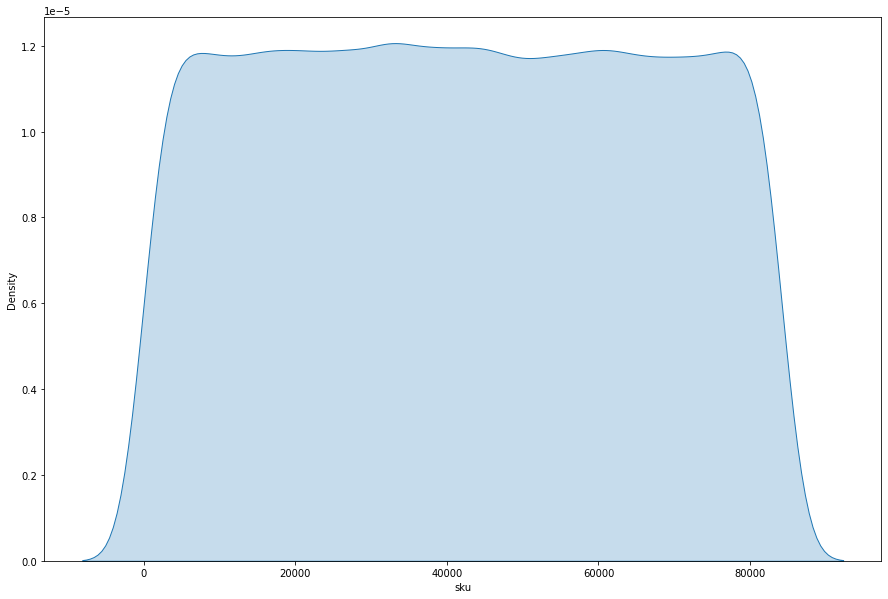

The skewness of national_inv is 26.218761407133158
The kurtosis of national_inv is 946.0195874018052


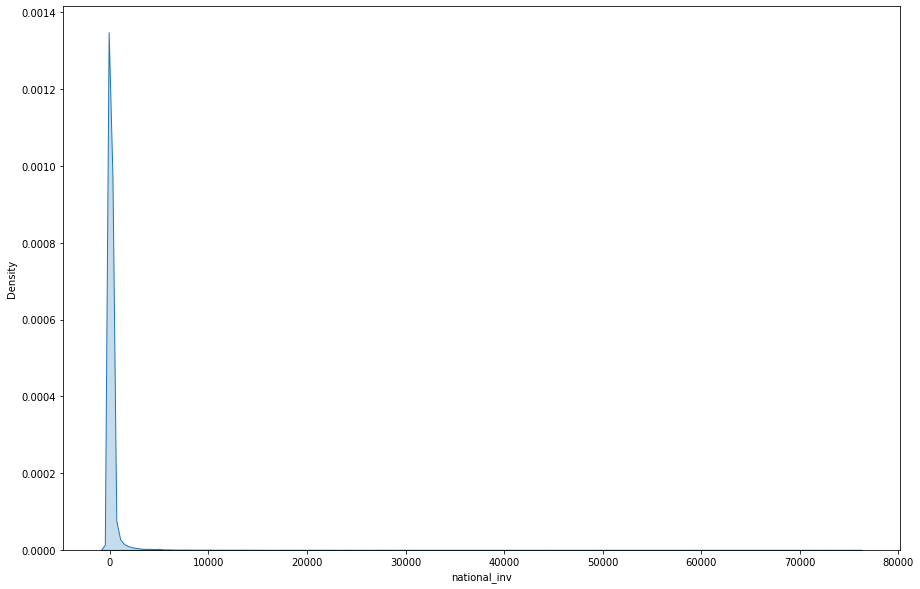

The skewness of lead_time is -0.01686135996362228
The kurtosis of lead_time is -0.471771347739812


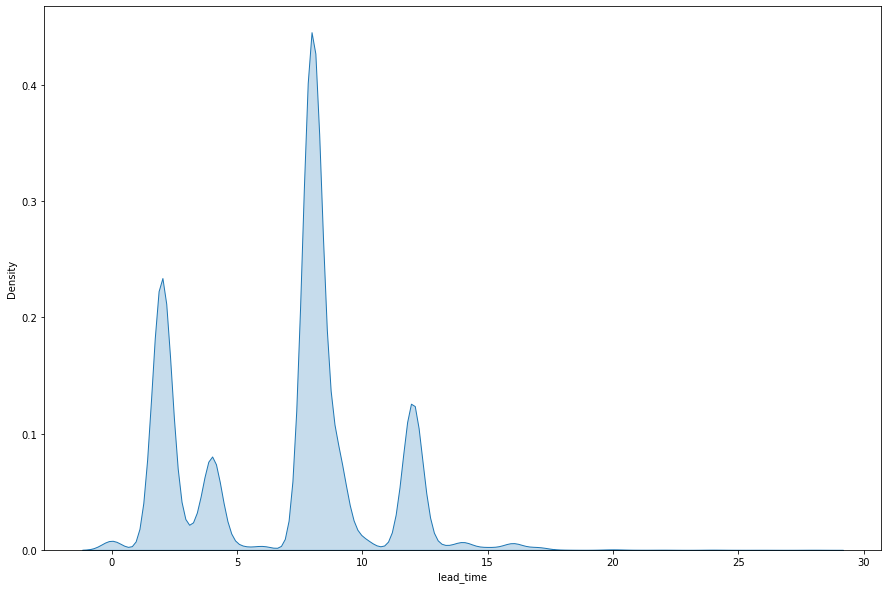

The skewness of in_transit_qty is 15.376587376904832
The kurtosis of in_transit_qty is 320.4235555622277


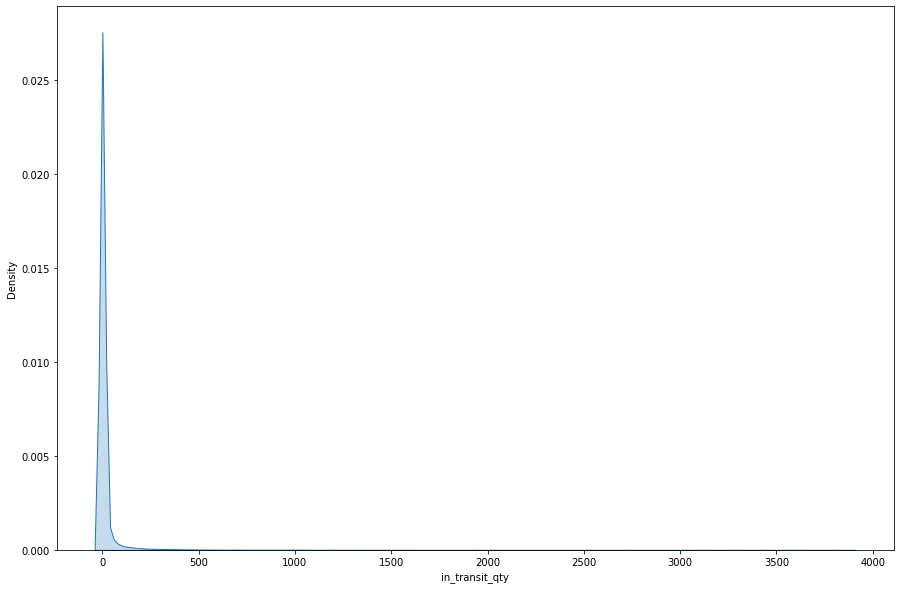

The skewness of forecast_3_month is 13.554718772883312
The kurtosis of forecast_3_month is 253.22489867870394


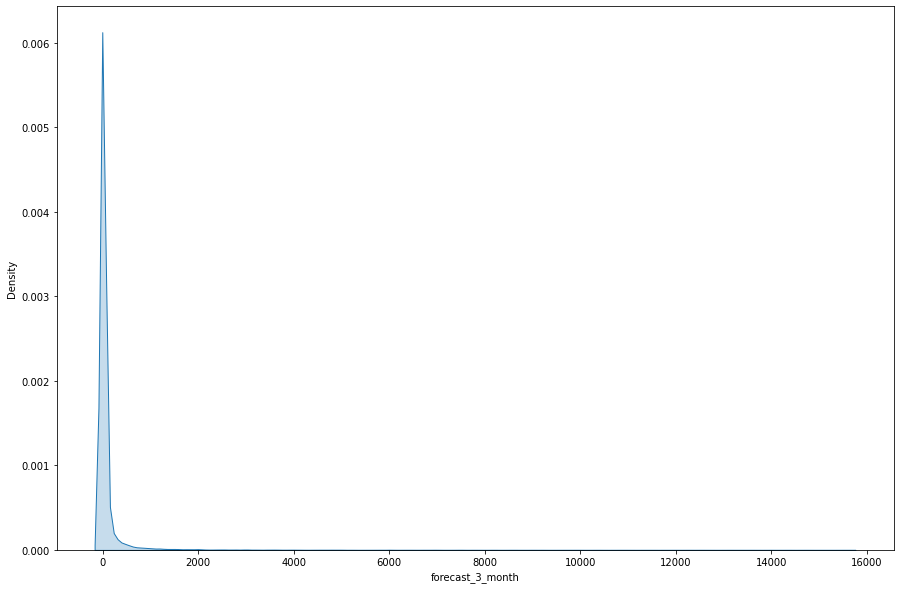

The skewness of forecast_6_month is 13.435191986074184
The kurtosis of forecast_6_month is 249.27525236222235


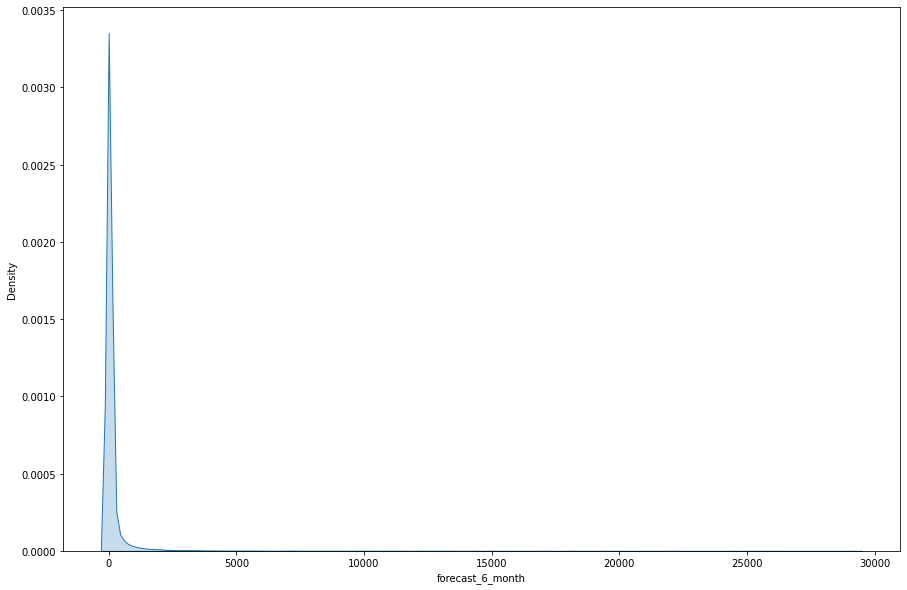

The skewness of forecast_9_month is 13.540964177043781
The kurtosis of forecast_9_month is 250.7860789988676


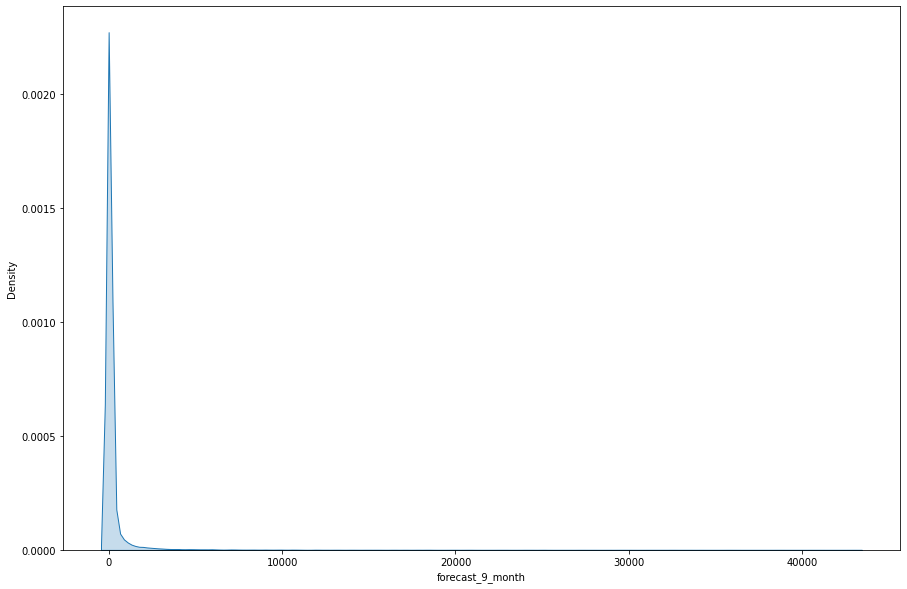

The skewness of sales_1_month is 13.88048916276609
The kurtosis of sales_1_month is 280.00510281420685


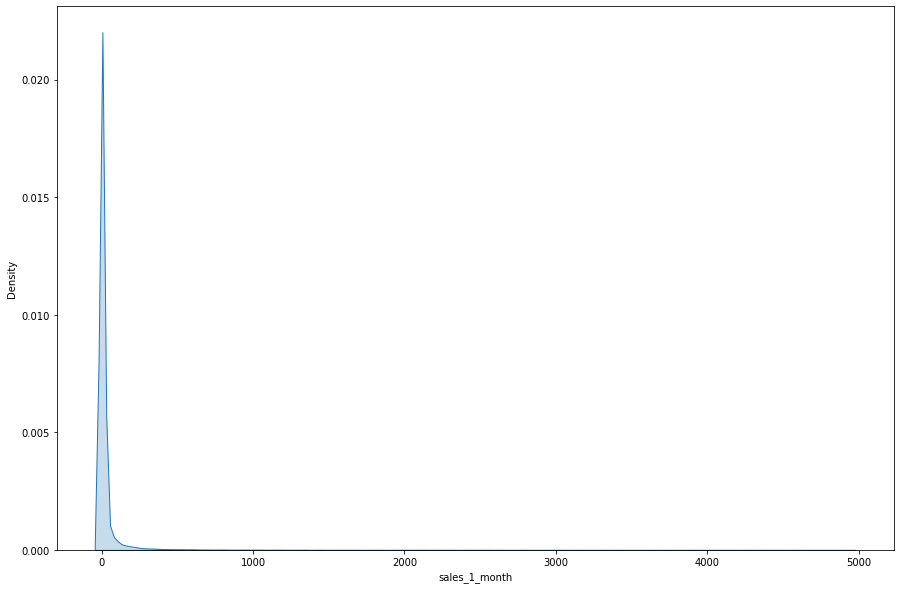

The skewness of sales_3_month is 12.666195340564755
The kurtosis of sales_3_month is 223.8563958886239


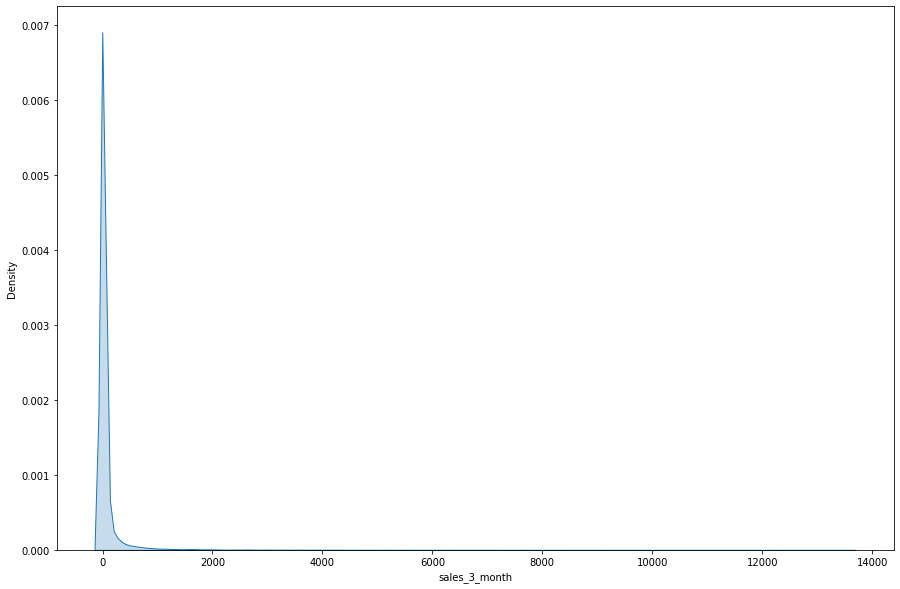

The skewness of sales_6_month is 12.82974372749714
The kurtosis of sales_6_month is 228.02010249904234


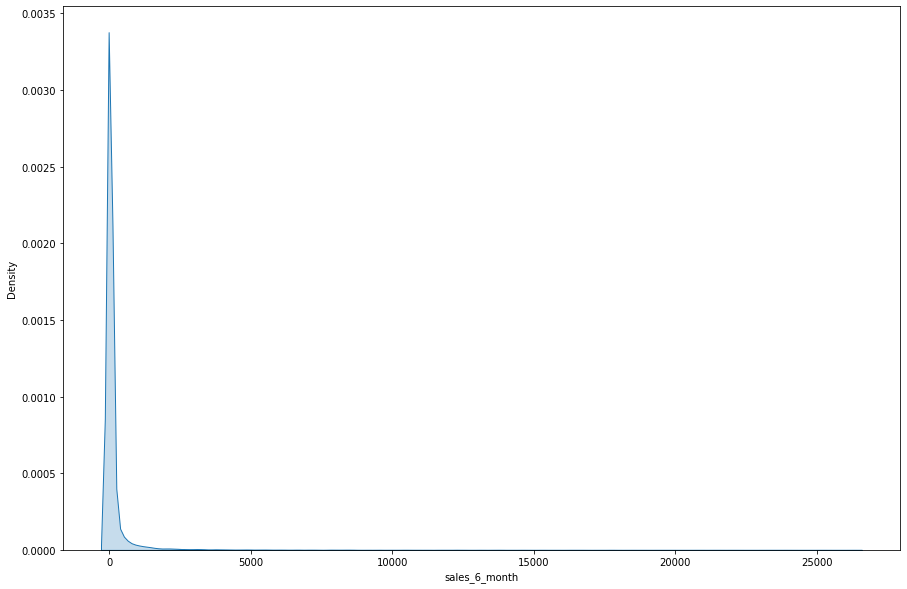

The skewness of sales_9_month is 13.338128182790323
The kurtosis of sales_9_month is 255.52846365134354


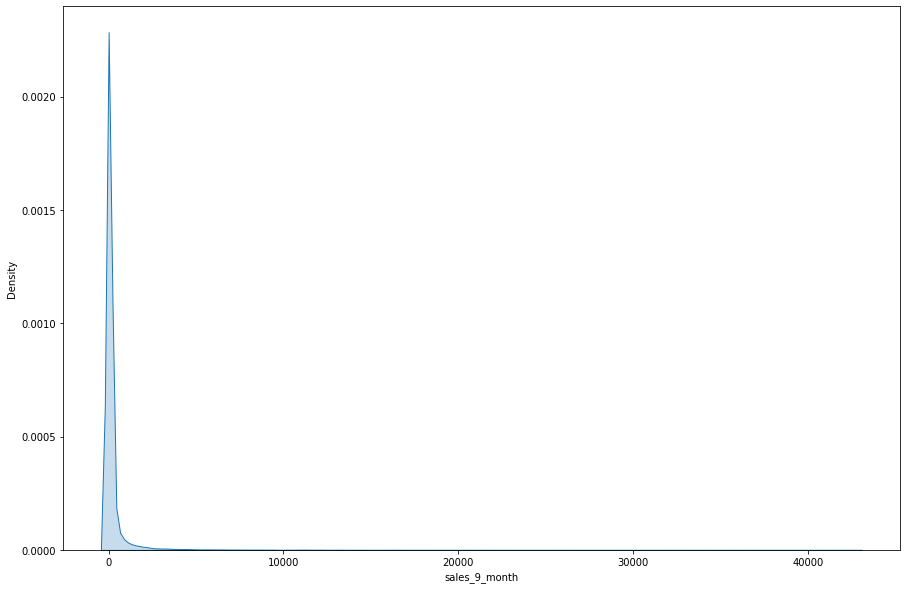

The skewness of min_bank is 12.015635215944398
The kurtosis of min_bank is 195.10817893636684


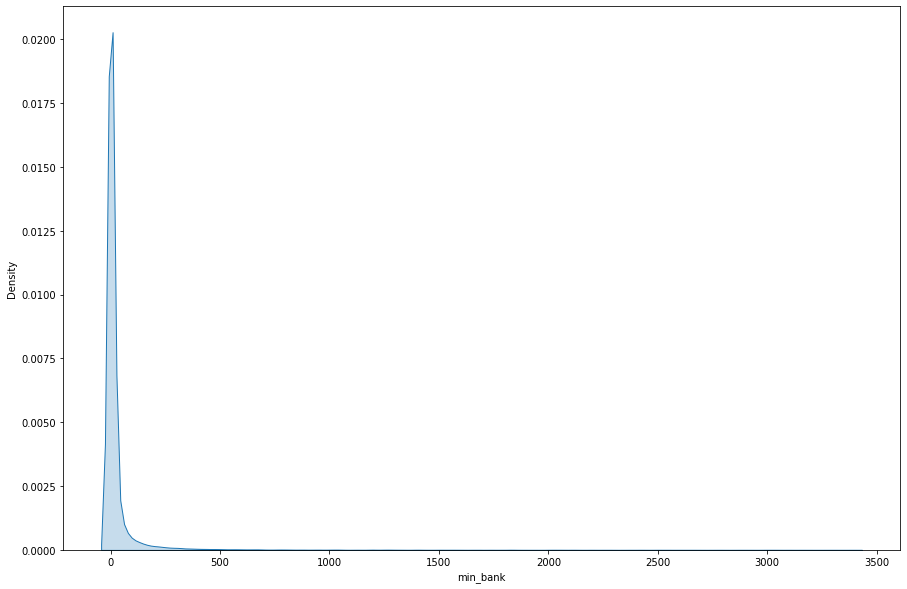

The skewness of potential_issue is 31.031199012315774
The kurtosis of potential_issue is 960.9679321082989


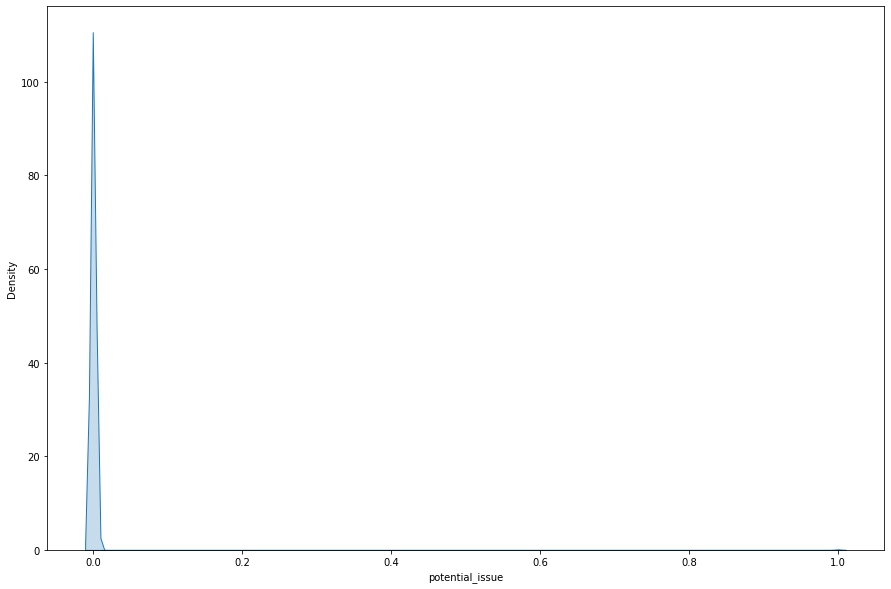

The skewness of pieces_past_due is 25.47929635269142
The kurtosis of pieces_past_due is 796.3752098874661


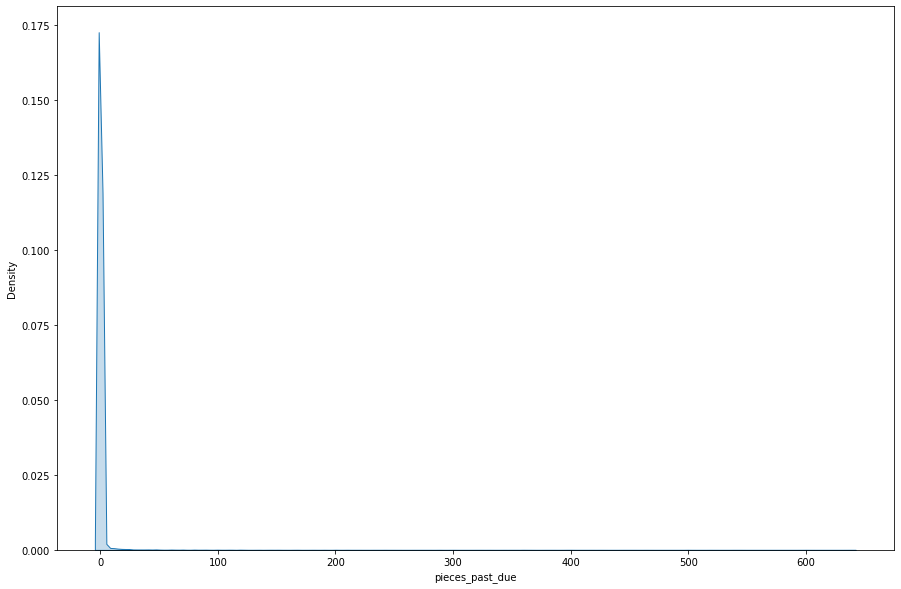

The skewness of perf_6_month_avg is -1.5041023237768323
The kurtosis of perf_6_month_avg is 1.8611818033786762


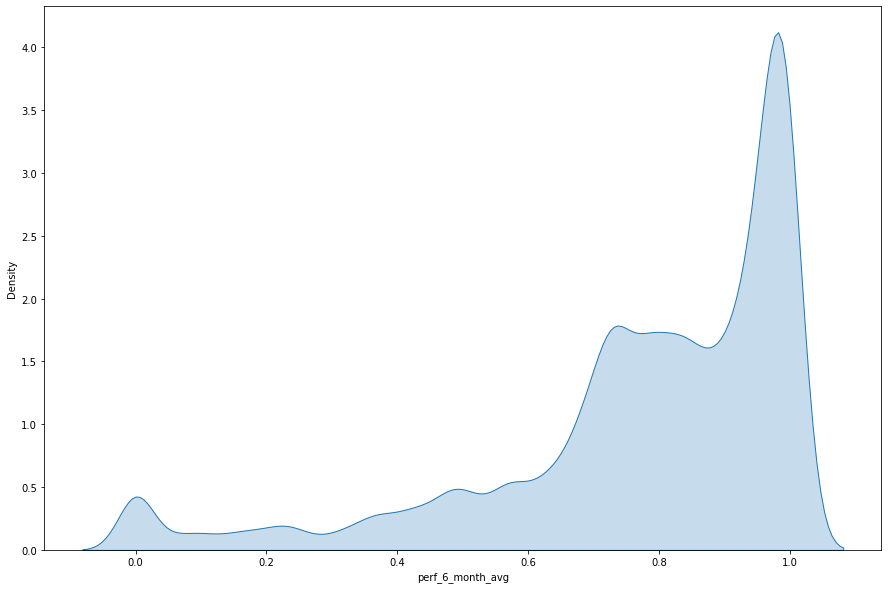

The skewness of perf_12_month_avg is -1.527267546191365
The kurtosis of perf_12_month_avg is 2.002128513801821


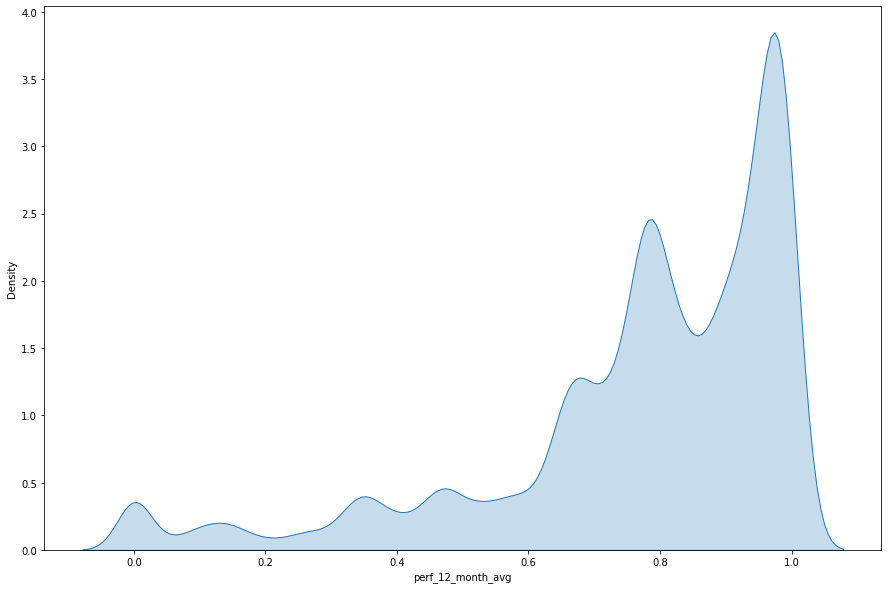

The skewness of local_bo_qty is 18.944508552578924
The kurtosis of local_bo_qty is 435.80983063080436


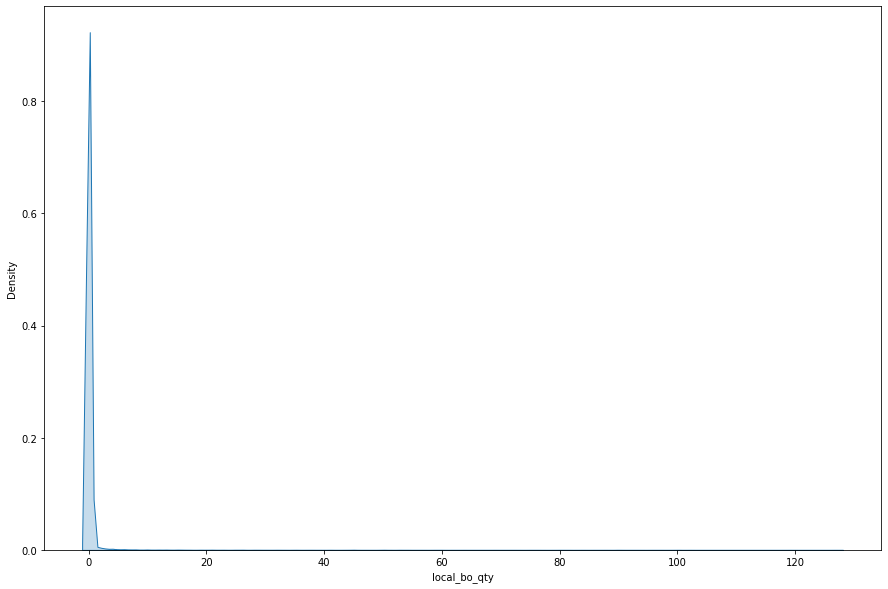

The skewness of deck_risk is 1.6619238205741542
The kurtosis of deck_risk is 0.7620166508241928


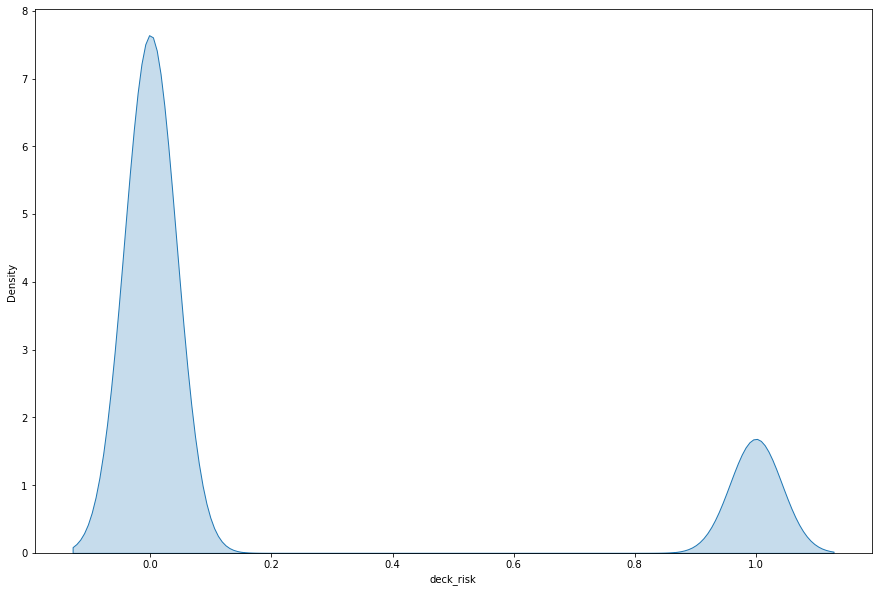

The skewness of oe_constraint is 73.16792672251921
The kurtosis of oe_constraint is 5351.727164754015


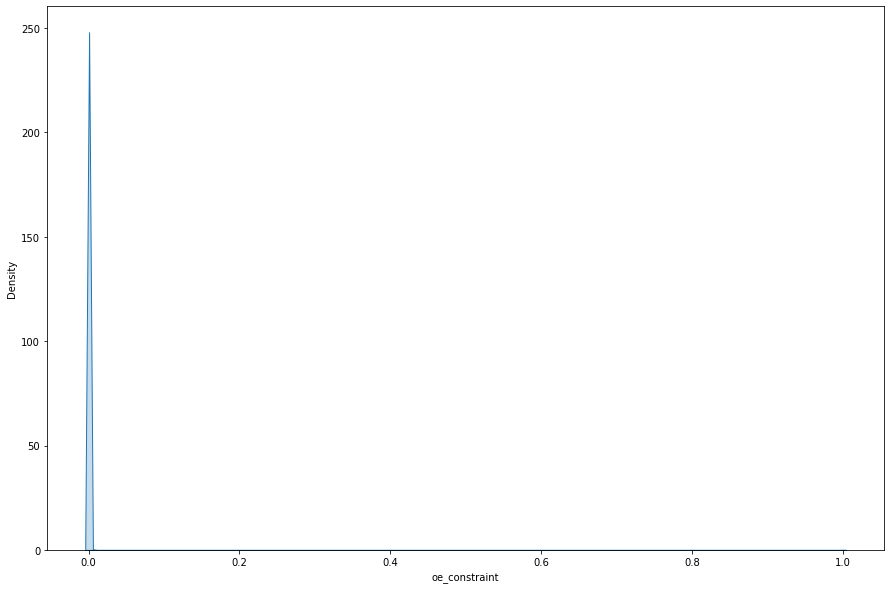

The skewness of ppap_risk is 2.3253328465777345
The kurtosis of ppap_risk is 3.4072885063139835


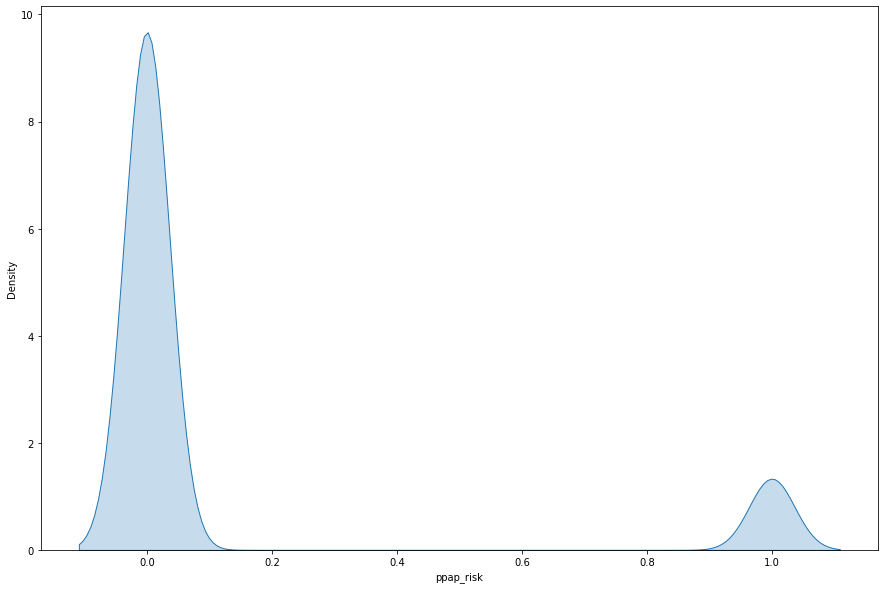

The skewness of stop_auto_buy is -7.29298707966429
The kurtosis of stop_auto_buy is 51.1893981623803


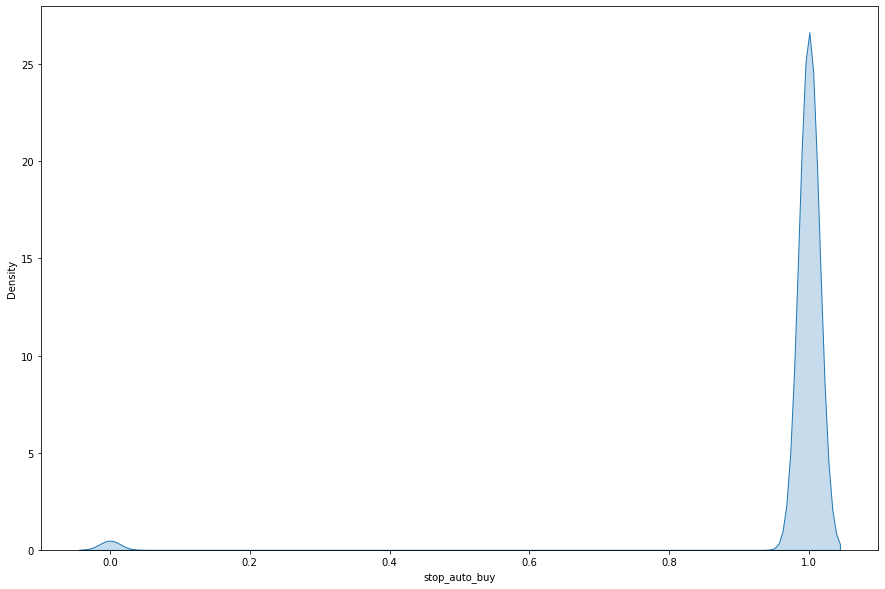

The skewness of rev_stop is 62.6508854230433
The kurtosis of rev_stop is 3923.266619212379


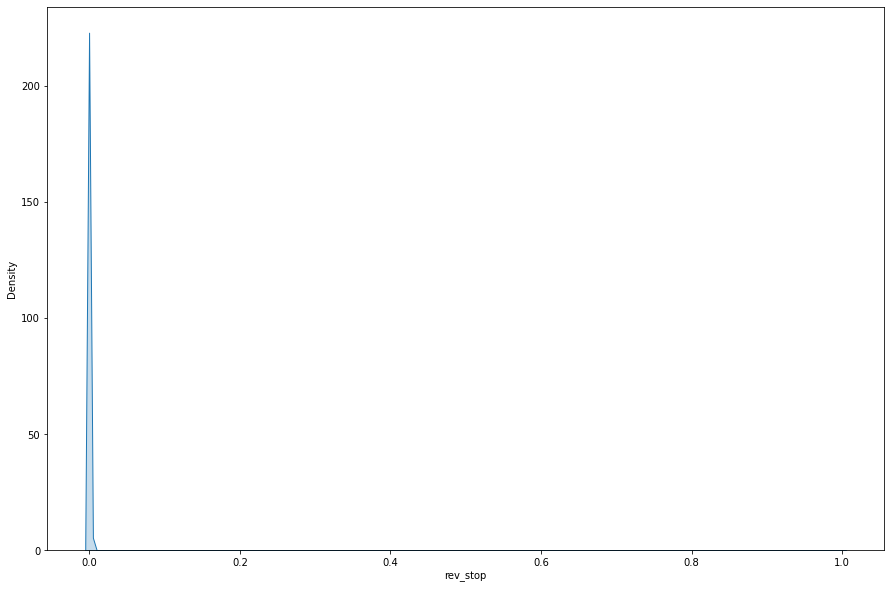

The skewness of went_on_backorder is 1.8778371602654675
The kurtosis of went_on_backorder is 1.5263242102556345


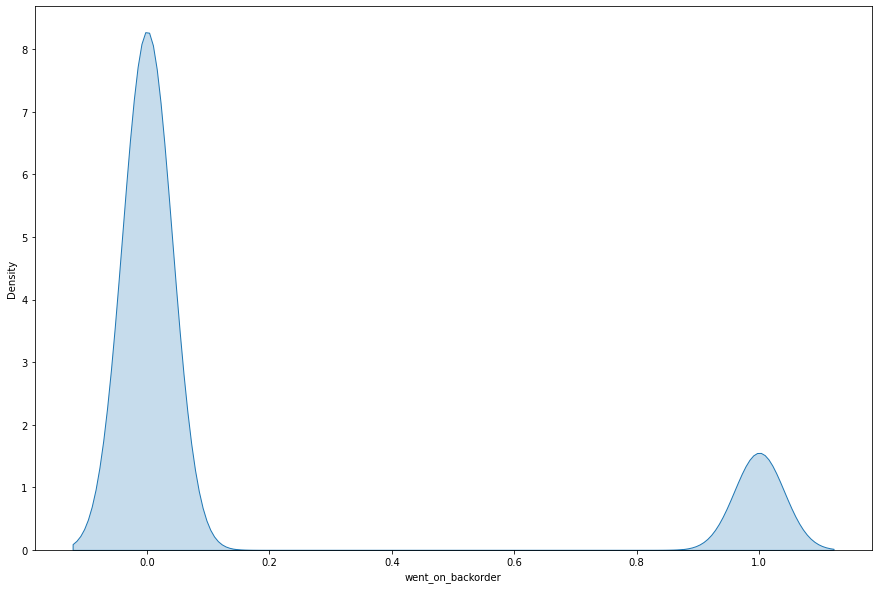

The skewness of firstboom is 13.90001420755358
The kurtosis of firstboom is 584.2650704677643


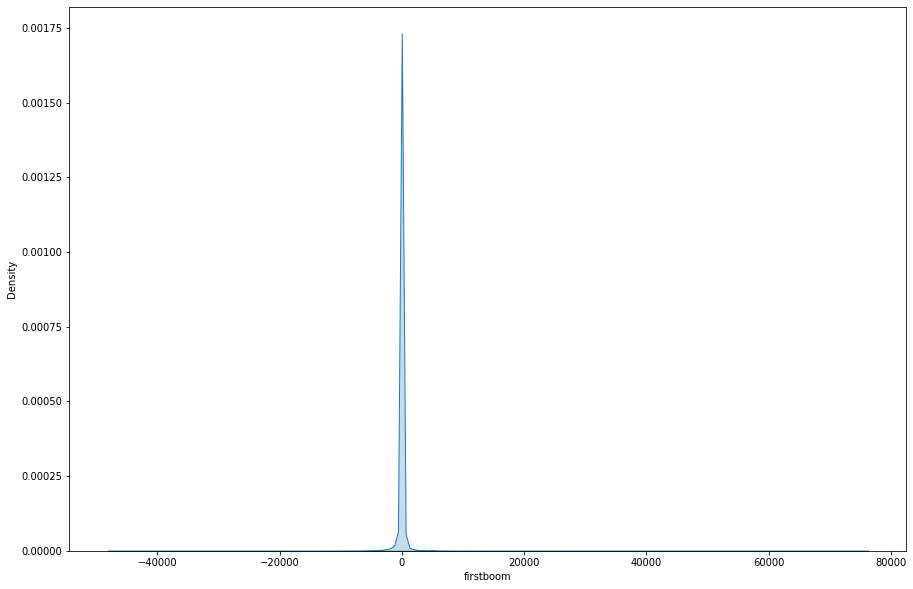

The skewness of firstboomh is 13.060055393913098
The kurtosis of firstboomh is 606.388092590895


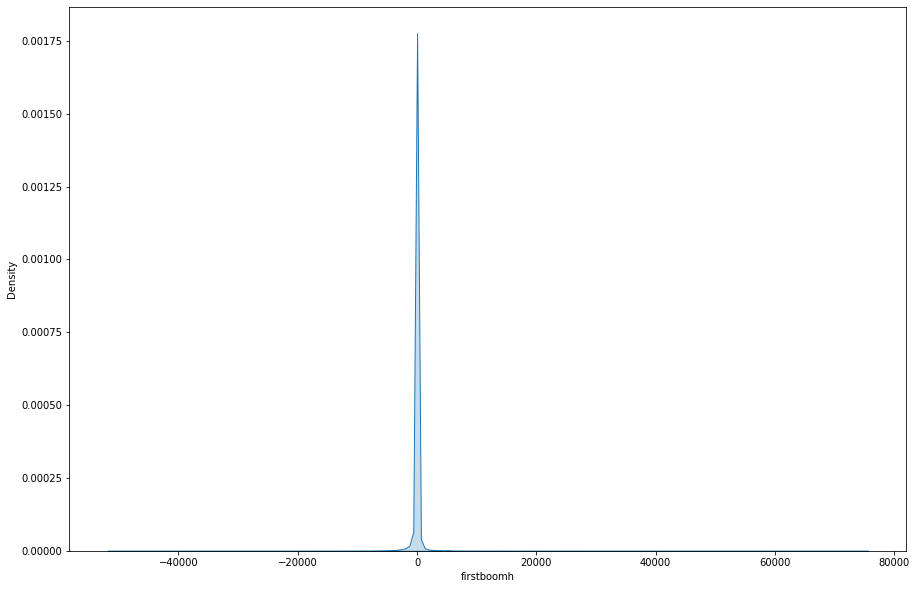

The skewness of secondboom is 15.541876909752382
The kurtosis of secondboom is 627.3721097401707


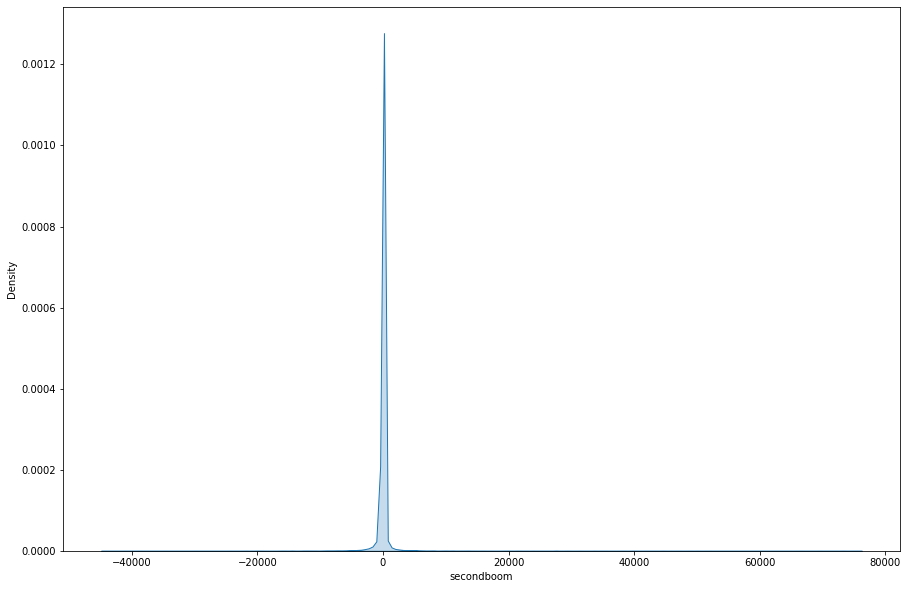

The skewness of secondboomh is 14.950021673805981
The kurtosis of secondboomh is 650.9457496041222


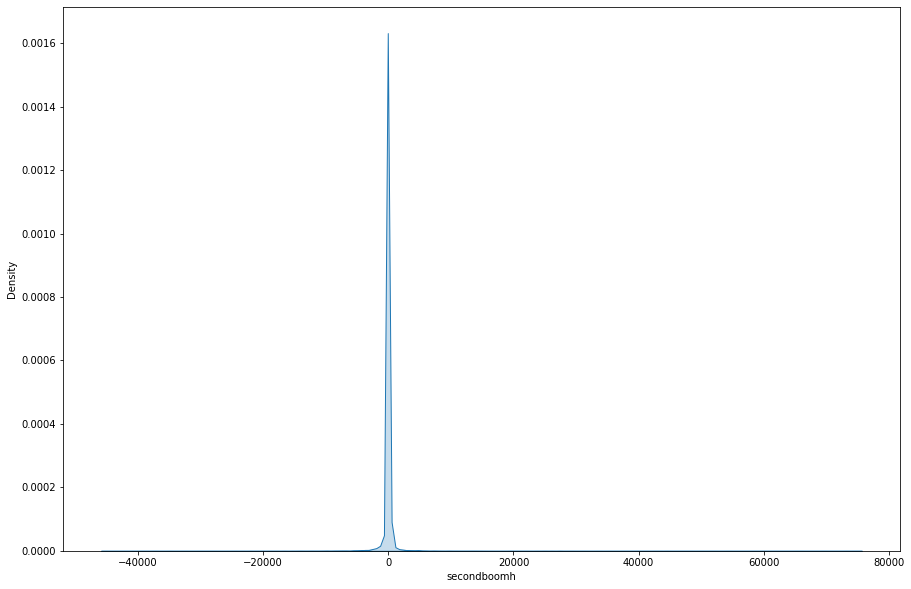

The skewness of boom is -38.75996972825559
The kurtosis of boom is 2287.9222373792704


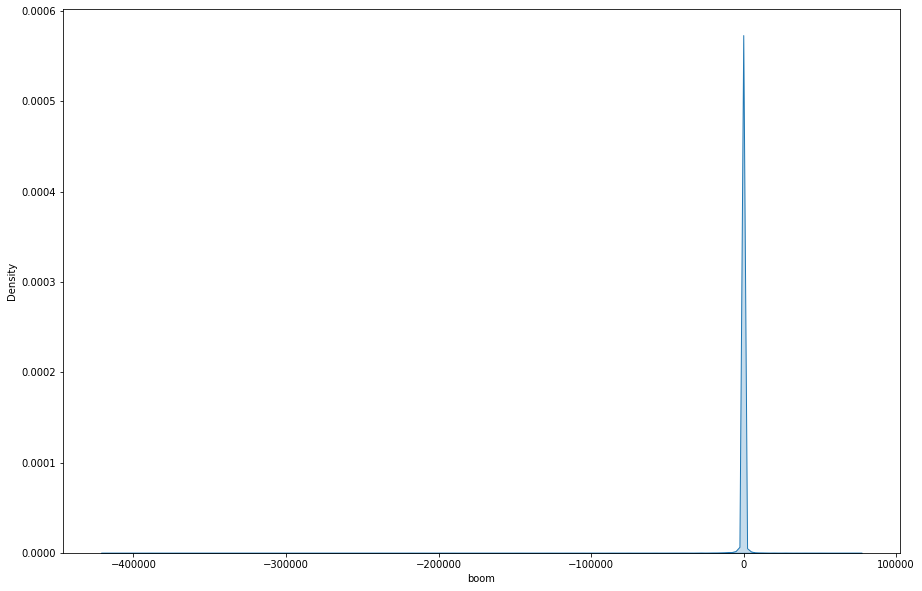

In [35]:
for i in catvar:
    plt.figure(figsize=(15,10))
    print(f'The skewness of {i} is {df_train[i].skew()}')
    print(f'The kurtosis of {i} is {df_train[i].kurtosis()}')
    sns.kdeplot(df_train[i],shade=True)
    label=i
    plt.show()

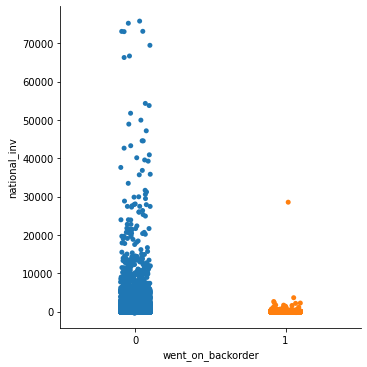

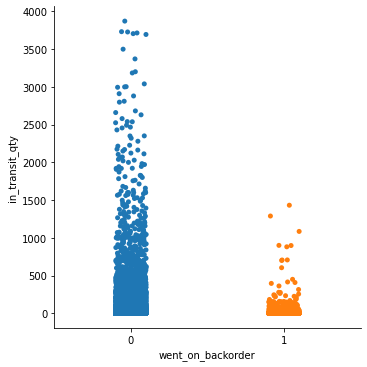

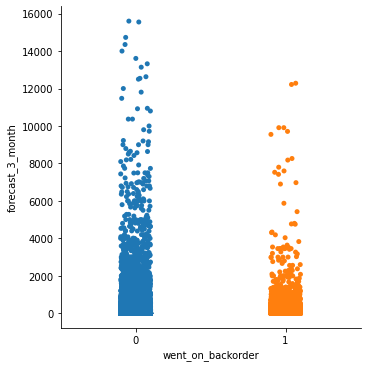

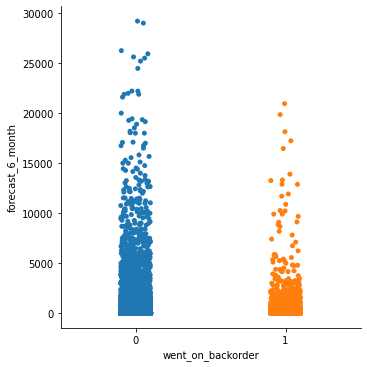

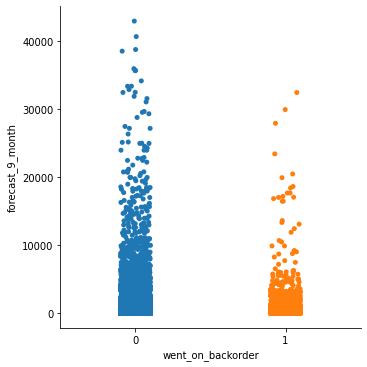

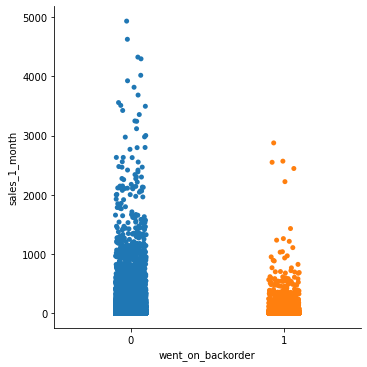

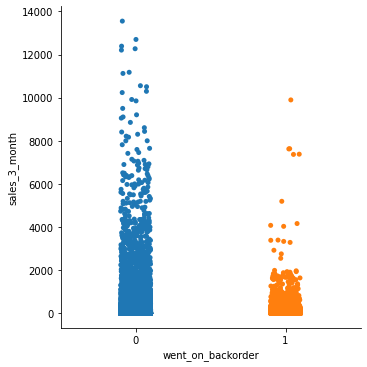

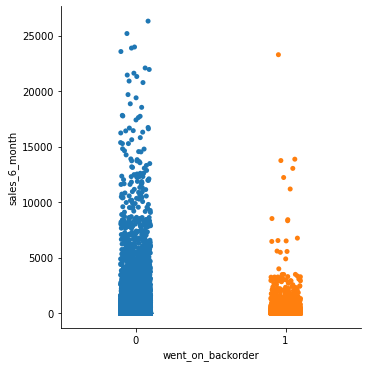

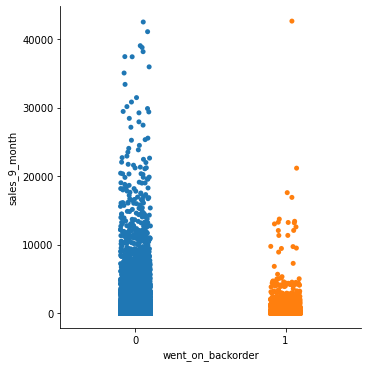

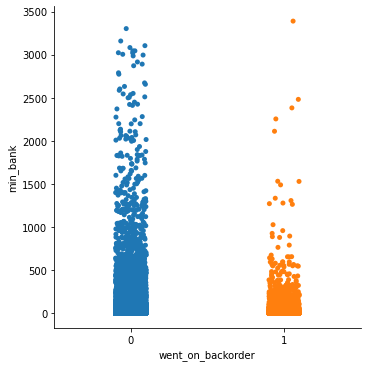

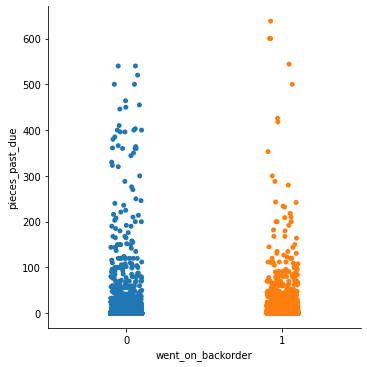

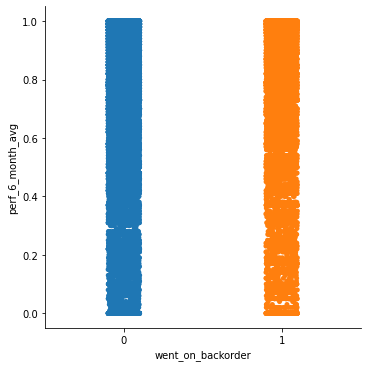

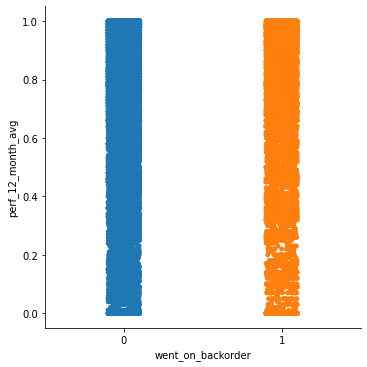

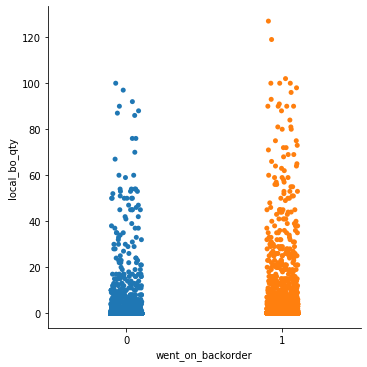

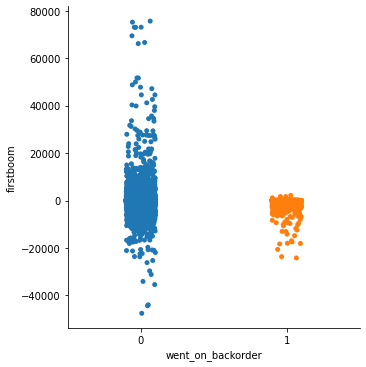

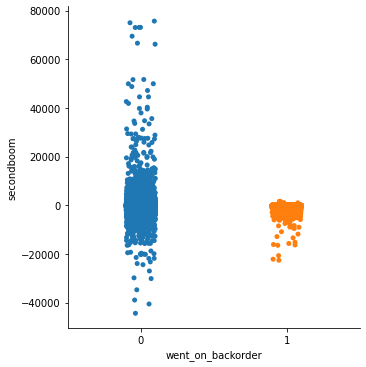

In [36]:


sns.catplot(x='went_on_backorder', y='national_inv',data = df_train)
sns.catplot(x='went_on_backorder', y='in_transit_qty', data = df_train)
sns.catplot(x='went_on_backorder', y='forecast_3_month',data = df_train)
sns.catplot(x='went_on_backorder', y='forecast_6_month',data = df_train)
sns.catplot(x='went_on_backorder', y='forecast_9_month',data = df_train)

sns.catplot(x='went_on_backorder', y='sales_1_month', data = df_train)
sns.catplot(x ='went_on_backorder',y='sales_3_month',data = df_train)
sns.catplot(x='went_on_backorder', y='sales_6_month',data = df_train)
sns.catplot(x='went_on_backorder', y='sales_9_month',data = df_train)

sns.catplot(x='went_on_backorder', y='min_bank', data = df_train)
sns.catplot(x='went_on_backorder', y='pieces_past_due', data = df_train)
sns.catplot(x='went_on_backorder', y='perf_6_month_avg',data = df_train)
sns.catplot(x='went_on_backorder', y='perf_12_month_avg',data = df_train)
sns.catplot(x ='went_on_backorder', y= 'local_bo_qty', data = df_train)

sns.catplot(x='went_on_backorder', y='firstboom',data = df_train)
sns.catplot(x ='went_on_backorder', y= 'secondboom', data = df_train)

plt.show()

<ipython-input-37-c59b2fbb322c>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df_train[catvar].corr(),dtype=np.bool)


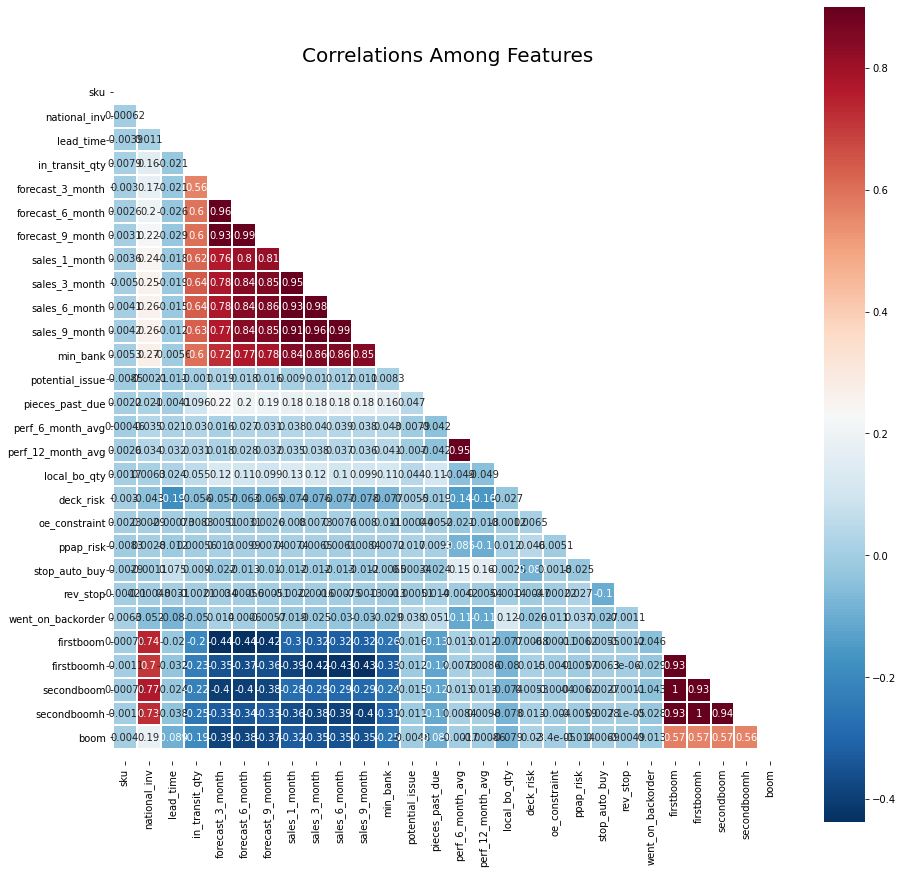

In [37]:
# 热力图呈现相关性

mask = np.zeros_like(df_train[catvar].corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig,ax= plt.subplots()
fig.set_size_inches(15,15)
sns.heatmap(df_train[catvar].corr(),
           annot=True,
           mask = mask,
           cmap = 'RdBu_r',
           linewidths=0.1,
           linecolor='white',
           vmax = .9,
           square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Correlations Among Features",fontsize = 20)
plt.show()

In [38]:
# 对数值标量用mannwhitneyu检验,minback指标？
for col in catvar[1:-6]:
    g1=df_train[col][df_train['went_on_backorder']==1]
    g2 =df_train[col][df_train['went_on_backorder']==0] 
    stat,p_val = mannwhitneyu(g1,g2)
    print(f'{col} - backorder status, statistic:{stat}, pval: {p_val}')

national_inv - backorder status, statistic:92326297.5, pval: 0.0
lead_time - backorder status, statistic:201407505.5, pval: 3.829731042776945e-93
in_transit_qty - backorder status, statistic:208085610.0, pval: 1.68850810686487e-103
forecast_3_month - backorder status, statistic:115784752.5, pval: 0.0
forecast_6_month - backorder status, statistic:121177272.0, pval: 0.0
forecast_9_month - backorder status, statistic:125718028.5, pval: 0.0
sales_1_month - backorder status, statistic:170113707.5, pval: 0.0
sales_3_month - backorder status, statistic:167780505.5, pval: 0.0
sales_6_month - backorder status, statistic:173193597.0, pval: 0.0
sales_9_month - backorder status, statistic:176695369.5, pval: 4.441406719312413e-290
min_bank - backorder status, statistic:229075816.5, pval: 0.1321602556416887
potential_issue - backorder status, statistic:229850495.5, pval: 9.341588239717567e-21
pieces_past_due - backorder status, statistic:214247861.0, pval: 0.0
perf_6_month_avg - backorder status, s

In [39]:
# 对二分类变量用z-test，rev_stop指标?
for col in catvar[-6:-1]:
    if col != 'lead_time_bins':
        CT = pd.crosstab(df_train[col],df_train['went_on_backorder'])
        x = np.array(CT[1])
        n = np.array(CT[0]+CT[1])
        stat,p_val = proportions_ztest(x,n)
        print(f'z_test for {col} and backorder : statistic {stat}, pvalue {p_val}')

z_test for went_on_backorder and backorder : statistic -242.73236290202428, pvalue 0.0


NotImplementedError: more than two samples are not implemented yet

undersampling

building model

In [ ]:
# X=df_train[['inv','1','1h','2','2h','risksign']]
X = df_train.drop(['sku',"went_on_backorder"], axis=1)

Y=df_train["went_on_backorder"]
X.drop(['deck_risk','oe_constraint','ppap_risk','rev_stop','stop_auto_buy','potential_issue'],axis = 1,inplace = True)
# X.drop(['forecast_3_month','forecast_6_month','forecast_9_month'],axis = 1,inplace = True)
# X.drop(['sales_1_month','sales_3_month','sales_6_month','sales_9_month'],axis = 1,inplace = True)
X.drop(['min_bank','lead_time','in_transit_qty','local_bo_qty'],axis = 1,inplace = True)
X.drop(['pieces_past_due','perf_6_month_avg','perf_12_month_avg'],axis = 1,inplace = True)
# X.drop(['national_inv'],axis = 1,inplace = True)

# X.drop(['one','oneh'],axis = 1,inplace = True)
# X.drop(['two','twoh'],axis = 1,inplace = True)
# X.drop(['national_inv'],axis = 1,inplace = True)


X.head()

1 Random Forest

In [ ]:
RF=RandomForestClassifier(n_estimators=200)

In [ ]:
x_train,x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=14)

In [ ]:
RF.fit(x_train,y_train)

In [ ]:
# predict labels
y_predict = RF.predict(x_test)
# predict probabilities
yhat = RF.predict_proba(x_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

In [ ]:
# dataframe for comparison
pred_df  =  pd.DataFrame(y_predict,columns=['Old_Prediction'])
pred_df['Old Probabilities'] = yhat
# AUC for default threshold (0.5)
fpr_1, tpr_1, th = roc_curve(y_test,  pred_df['Old_Prediction'])
roc_auc = auc(fpr_1, tpr_1)
print("Default Area under the ROC curve : %f" % roc_auc)

In [ ]:
#confusion matrix for default threshold
cf_matrix = confusion_matrix(y_test,  pred_df['Old_Prediction'])
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.title('Confusion Matrix for Default Threshold')
sns.heatmap(cf_matrix, annot=labels, fmt="")

In [ ]:
df_feature=pd.DataFrame(RF.feature_importances_)
df_feature.columns=["importance"]
df_feature["feature"]=x_train.columns
df_feature.sort_values(by="importance",ascending=False,inplace=True)
df_feature

In [ ]:
#Threshold Moving
#func for best threshold
def best_threshold(tpr,fpr):
    J = tpr - fpr
    ix = np.argmax(J) 
    best_thresh = thresholds[ix]
    return(f'Best Threshold',np.round(best_thresh,6))

In [ ]:
# calculate roc curves with probability
fpr, tpr, thresholds = roc_curve(y_test, yhat)

best_threshold(tpr,fpr)

In [ ]:
# plot the roc curve for the model
ix = np.argmax(tpr - fpr)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='RandomForest')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [ ]:
#Calculating  AUC-ROC using revised decision Threshold
pred_df['New Prediction'] = pred_df['Old Probabilities'].map(lambda x : 1 if x >= best_threshold(tpr,fpr)[1] else 0)

#New Area  Under-ROC
fpr_new, tpr_new, _ = roc_curve(y_test,  pred_df['New Prediction'])
roc_auc = auc(fpr_new, tpr_new)
print("New Area under the ROC curve: %f" % roc_auc)

In [ ]:
#confusion matrix for revised decision threshold
cf_matrix = confusion_matrix(y_test,  pred_df['New Prediction'])
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.title('Confusion matrix for revised Threshold')
sns.heatmap(cf_matrix, annot=labels, fmt="")

Default Threshold

In [ ]:
# 过拟合，通过交叉验证进行消除
from sklearn.metrics import roc_auc_score
pred_train=RF.predict(x_train)   
#roc_auc
print(f'The training roc_auc score is : {roc_auc_score(y_train,pred_train)}')
print(f"The testing roc_auc score is : {roc_auc_score(y_test, pred_df['Old_Prediction'])}")
print('\n')
#accuracy
print(f"The training accuracy score is {accuracy_score(y_train,  pred_train)}")
print(f"The testing accuracy score is {accuracy_score(y_test,  pred_df['Old_Prediction'])}")
print('\n')
#Recall
print(f"The training recall score is {recall_score(y_train,  pred_train)}")
print(f"The testing recall score is {recall_score(y_test,  pred_df['Old_Prediction'])}")
print('\n')
#Precission
print(f"The training precision score is {precision_score(y_train,  pred_train)}")
print(f"The testing precision score is {precision_score(y_test,  pred_df['Old_Prediction'])}")

In [ ]:
#roc_auc
print(f'The training roc_auc score is : {roc_auc_score(y_train,pred_train)}')
print(f"The testing roc_auc score is : {roc_auc_score(y_test, pred_df['New Prediction'])}")
print('\n')
#accuracy
print(f"The training accuracy score is {accuracy_score(y_train,  pred_train)}")
print(f"The optimum threshold accuracy score in {accuracy_score(y_test,  pred_df['New Prediction'])}")
print('\n')
#Recall
print(f"The training recall score is {recall_score(y_train,  pred_train)}")
print(f"The optimum threshold recall score in {recall_score(y_test,  pred_df['New Prediction'])}")
print('\n')
#Precission
print(f"The training precision score is {precision_score(y_train,  pred_train)}")
print(f"The optimum threshold precision score in {precision_score(y_test,  pred_df['New Prediction'])}")

In [ ]:
# Tuned Threshold

label2 = [pred_train,pred_df['Old_Prediction'],pred_train,pred_df['New Prediction']]
label1 = [y_train,y_test,y_train,y_test]
data = np.array([[roc_auc_score(label1[i],label2[i]) for i in range(4)],
                 [accuracy_score(label1[i],label2[i]) for i in range(4)],
                 [recall_score(label1[i],label2[i]) for i in range(4)],
                 [precision_score(label1[i],label2[i]) for i in range(4)]])

header = pd.MultiIndex.from_product([['Default Threshold','Tuned Threshold'],
                                     ['Training Score','Test Score']],
                                    names=['Random Forest','Scores'])
df = pd.DataFrame(data,index=['roc_auc','accuracy','recall','precision'],columns=header)
df

Feature Imporatance

In [ ]:
df_feature=pd.DataFrame(RF.feature_importances_)
df_feature.columns=["importance"]
df_feature["feature"]=x_train.columns
df_feature.sort_values(by="importance",ascending=False,inplace=True)
df_feature

In [ ]:
df_feature.sort_values(by="importance",ascending=True,inplace=True)

plt.figure(figsize=(20,10))

y_pos=np.arange(26)
plt.title("Feature Importance",)
plt.barh( y_pos,df_feature["importance"])
plt.yticks(y_pos,df_feature["feature"])

plt.show()

In [ ]:
# 读入test
df = pd.read_csv('test.csv')
x = df.drop(["sku"] , 1)
y = df['sku']

y_pred = pd.DataFrame(RF.predict_proba(x))
y_pred = pd.DataFrame(y_pred.drop([0], axis=1).values)
y_pred = y_pred.rename(columns={ 0 : 'went_backorder_Prob'})
y_pred_final = pd.concat([y,y_pred],axis=1)
y_pred_final


In [ ]:
y_pred_final['predicted'] = y_pred_final.went_backorder_Prob.map( lambda x: 1 if x > 0.5 else 0)
# result=y_pred_final.drop(['went_on_backorder'], axis=1).values
result=y_pred_final.drop(['went_backorder_Prob'], axis=1).values
# x = df.drop(['went_on_backorder'], axis=1).values
from pandas import DataFrame
# print(str(len(y_pred_final)))
df = DataFrame(result,index=None,columns = ['sku','target'])
df.sort_values('sku', axis=0, ascending=True, inplace=True)
df.to_csv('sample.csv',header=0,index=0)